<br><br><font color="gray">INTEG 440 / 640<br>MODULE 7 of *Doing Computational Social Science*</font>

# <font color="green" size=40>COHESION & EQUIVALENCE: DETECTING SUBGROUPS IN SOCIAL NETWORKS</font>

<br>

Dr. [John McLevey](http://www.johnmclevey.com)    
Department of Knowledge Integration   
Department of Sociology & Legal Studies     
University of Waterloo         

<hr>

* INTEG 440 (Undergraduate): This module is worth <font color='#437AB2'>**8%**</font> of your final grade. The questions in this module add up to 10 points. 
* INTEG 640 (Graduate): This module is worth <font color='#437AB2'>**5%**</font> of your final grade. The questions in this module add up to 10 points. 

<hr>

# Table of Contents 

* [Overview](#o)
* [Learning Outcomes](#lo) 
* [Prerequisite Knowledge](#pk) 
* [Assigned Reading](#ar) 
* [Question Links](#ql)
* [Packages Used in this Module](#packs)
* [Data Used in this Module](#data)
* [**Detecting Cohesive Subgroups**](#dcs)
    * [**Louvain Community Detection**](#lcd)
    * [**$k$-Clique Communities**](#kcc)
    * [**Components and $k$-Cores**](#kcores)
    * [**$k$-Components and Structural Cohesion**](#sce)
* [**Equivalence and Positional Analysis**](#epa)
* [**Combining Cluster Analysis and Centrality Analysis**](#combo) 
    * [**Distributions of Centrality Scores Across Groups**](#cdist)
    * [**Group Degree and Group Betweenness Centrality**](#gc)
* [References](#refs) 

<hr>   

# Overview <a id='o'></a>

This Module builds on the last two modules and introduces new types of analysis that are broadly focused on identifying subgroups of nodes in networks. First we will focus on a set of methods that are used to identify cohesive subgroups (or "communities") in networks. Next, we will shift to a different type of analysis that clusters nodes based on the similarity of their structural position in networks rather than their immediate social ties. Finally, we will explore two ways of combining this type of analysis with the centrality analyses we conducted in the previous Module. 

<hr>

# Learning Outcomes  <a id='lo'></a>

Upon successful completion of this module, you will be able to: 

1. Conduct and interpret a cohesive subgroups analysis using multiple approaches
2. Conduct and interpret a block model analysis 
3. Conduct and interpret an analysis of group centralities using communities and blocks as groups 

<hr>

# Prerequisite Knowledge  <a id='pk'></a>

This module assumes basic comfort with the fundamentals of Python and knowledge of network thinking and relational data structures introduced in the previous module. 

<hr>

# Assigned Readings  <a id='ar'></a>

This module assumes you have completed the assigned readings, which are listed immediately below. The readings provide a detailed explanation of the core concepts covered in this module. 

* <font color="green">John Scott. 2013. Chapter 6: "Components, Cores, and Cliques" from *Social Network Analysis*. Sage.</font> 
    * Note: You can skim the content on "cyclic components" from the Scott reading. It is useful to know about cyclic components but they are not covered in this Module. 
* <font color="green">Steve Borgatti, Martin Everett, and Jeff Johnson. 2016. Chapter 12: "Equivalence" in *Analyzing Social Networks*. Sage. </font> 
    * Note: You can ignore any references to the software UCINET. 
* <font color="green">Charles Kadushin. 2012. Chapter 4: "Basic Network Concepts, Part III: Network Segmentation" from *Understanding Social Networks*. Oxford University Press.</font> 


As always, I recommend that you (1) complete the assigned readings, (2) attempt to complete this module without consulting the readings, making notes to indicate where you are uncertain, (3) go back to the readings to fill in the gaps in your knowledge, and finally (4) attempt to complete the parts of this module that you were unable to complete the first time around.

This module notebook includes highly condensed overviews of *some* of the key material from the assigned reading. This is intended as a *supplement* to the assigned reading, *not as a replacement for it*. These high-level summaries do not contain enough information for you to successfully complete the exercises that are part of this module, and they do not cover every relevant topic. 

<hr>

# Question Links <a id='ql'></a>

Make sure you have answered all of the following questions before submitting this notebook on LEARN. 

1. [Question 1](#yt1) 
2. [Question 2](#yt2) 
3. [Question 3](#yt3) 
4. [Question 4](#yt4) 
5. [Question 5](#yt5) 
6. [Question 6](#yt6) 
7. [Question 7](#yt7) 
8. [Question 8](#yt8) 
9. [Question 9](#yt9) 

<hr>

# Packages Used in this Module  <a id='packs'></a> 

The cell below imports the packages that are necessary to complete this module. If there are any additional packages you wish to import, you may add them to this import cell. 

In [147]:

!pip install python_louvain
import pandas as pd 
import networkx as nx 
import community

# not imported into the top-level networkx namespace, so we have to import it directly 
from networkx.algorithms.community import k_clique_communities 

# for block modelling 
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# make inline plots vector graphics instead of raster. 
%config InlineBackend.figure_format = 'svg'

# make Python quieter... 
import warnings
warnings.filterwarnings('ignore')

# Data Used in this Module  <a id='data'></a>

In this module, we will continue using the personal ego network datasets we constructed in Module 5 and started analyzing in Module 6. That data was saved in the `data` directory as an edgelist and as an adjacency matrix. Here, we will load the edgelist version of the dataset. 

We will also use anonymized network dataset collected by Margaret Weeks et al. (2002) for their multi-method network study of drug users in Hartford Connecticut. The nodes in the network are people who have injected drugs or used crack cocaine. The edges between nodes indicate a "significant personal relationship" with someone they have used drugs with. The overarching goal of the study this data was collected for was to better understand how the structure of social ties affects HIV transmission and prevention. Note that this network is not weighted (the edgelist only includes data on $i$, $j$ pairs and node IDs are used in place of names). The full dataset includes many node attributes that we have not included here for obvious reasons. 

The data is stored in a csv file called `hartford_drug.csv` in the `data` subdirectory of the course folder. We will read it into memory later in this module. 

### Hartford Drug Use Network

In [148]:
el = pd.read_csv('data/hartford_drug.csv')
G = nx.from_pandas_edgelist(el, source = 'i', target = 'j')
G.name = 'Drug Sharing Network'
print(nx.info(G))

Name: Drug Sharing Network
Type: Graph
Number of nodes: 212
Number of edges: 284
Average degree:   2.6792


### McLevey Ego Network

And now we will read in my ego network from the previous Module. 

In [149]:
ego_el = pd.read_csv('data/jm_ego_data_el.csv')
ego = nx.from_pandas_edgelist(ego_el)
ego.name = 'Personal Network'
print(nx.info(ego))

Name: Personal Network
Type: Graph
Number of nodes: 62
Number of edges: 328
Average degree:  10.5806


We will also need to load up the centralities `dataframes` constructed in the last Module. Here's it is for my network:

In [150]:
centralities = pd.read_csv('data/centralities_egonet_jm.csv')
centralities.sample(5)

,Degree,Eigenvector,Betweenness,Node ID,Current Flow Betweenness,Constraint
26,0.245902,0.201106,0.011698,Mary M,0.061938,0.200806
11,0.295082,0.141054,0.049807,Vanessa S,0.113753,0.162267
57,0.081967,0.004975,0.064481,Martin I,0.080567,0.406965
23,0.278689,0.205406,0.005185,Dom RB,0.053878,0.189236
4,0.213115,0.165114,0.001901,Thom C,0.037063,0.206267


### Your Ego Network

Finally, we will load *your* ego network data, created in the previous Module. Be sure to change the name of the file from `jm_ego_data_el.csv` to whatever you named your ego network edgelist data. 

In [151]:
your_file = 'ps_ego_data_el.csv'
ego_el_stu = pd.read_csv('data/{}'.format(your_file))
ego_stu = nx.from_pandas_edgelist(ego_el_stu)
ego_stu.name = 'Personal Network'
print(nx.info(ego_stu))

Name: Personal Network
Type: Graph
Number of nodes: 50
Number of edges: 166
Average degree:   6.6400


In the cell below, change the file name to load up the centralities `dataframe` for *your* ego network. 

In [152]:
centralities_stu = pd.read_csv('data/centralities_egonet_ps.csv')
centralities_stu.sample(20)

,Degree,Eigenvector,Betweenness,Node ID,Current Flow Betweenness,Constraint
7,0.224490,0.268685,0.002232,Shreya S,0.060237,0.286580
31,0.102041,0.007302,0.001482,Gagan S,0.040369,0.418515
8,0.224490,0.268616,0.000319,Revanth Sakthi,0.047251,0.289359
28,0.061224,0.006131,0.000000,Jivanpal S,0.024738,0.438372
15,0.183673,0.203754,0.219388,Robi Sanchez,0.247121,0.250510
9,0.224490,0.268685,0.002232,Daniel H,0.060237,0.286580
5,0.306122,0.303184,0.145195,Harsh Chokshi,0.198645,0.214303
43,0.081633,0.002280,0.000000,Maggie K,0.025794,0.680937
18,0.102041,0.016455,0.008674,Gurmeet Singh,0.070366,0.414610
4,0.244898,0.285097,0.003741,Emad Ahmed,0.064334,0.281701


Throughout this notebook I will include example analyses of my own network or of the drug use network. At various parts of the notebook I will ask you to conduct and interpret a similar analysis of your personal network data. So make sure you correctly load your network -- you will need it to complete this Module. 

# Detecting Cohesive Subgroups<a id='dcs'></a>

Along with centrality analysis, detecting cohesive subgroups and analyzing the relationships among groups is probably one of the most common applications of network analysis. As you know from the assigned readings (especially Scott and Kaduschin), there are *many* ways of detecting cohesive subgroups, and they do not necessarily have a lot in common. In this Module, we are going to cover four main approaches: (1) Louvain community detection, (2) $k$-clique communities, (3) components and $k$-cores, and (4) $k$-components and structural cohesion analysis. 

Louvain is a widely-used approach that partitions networks into mutually-exclusive communities with more connections internally to one another than they do externally to other regions of the network. In other words, communities *do not overlap*. Edges can, of course, exist between nodes in two different communities, but the nodes themselves can only belong to one community. 

By contrast, the $k$-clique communities approach is designed to allow nodes to belong to more than one community. This is a more realistic approach to community detection for real-world social networks, as people in the real world are nearly always embedded in multiple communities. This approach works by starting with small groups of densely connected nodes ($k$-cliques) and builds up to larger communities by combining adjacent groups of densely connected nodes. 

Components are generally not considered "communities," but they are the starting point for community detection algorithms that start at the top level of a network and work their way down to the lower levels of a network, revealing increasingly cohesive subgroups of nodes along the way. In other words, they start from the opposite direction of a $k$-clique communities analysis; top down rather than bottom up. One approach -- $k$-core analysis -- identifies the most connected nodes in a component, revealing a component's 'core.' Other methods, like structural cohesion analysis, reveal the core of a component by progressively disconnecting components at their weakest points. Like $k$-clique communities, these approaches allow nodes to be part of multiple cohesive subgroups, but this means something a little different than what is meant by the $k$-clique communities approach. Here, cohesive subgroups are hierarchically nested, so one can be part of multiple cohesive subgroups in the sense that some subgroups are nested inside other, larger, subgroups. 

Let's work our way through each of these methods. 

## Louvain Community Detection<a id='lcd'></a>

The Louvain community detection algorithm relies on measure called "modularity" ($Q$), which describes how *modular* the structure of a network is by analyzing the density of edges within a group to edges outside the group. The more modular a network is, the more distinct "communities" it is composed of. In other words, network with higher $Q$ are made up of communities that are have a lot of internal ties and relatively few external ties. $Q$ ranges from -1 to 1. 

The Louvain community detection algorithm attempts to partition a network into communities by optimizing the modularity $Q$ of the network as nodes are assigned to different communities. The first set of steps are part of a "greedy" phase. First, each node in the network is assigned to it's own community and $Q$ is computed for the network. Next, the algorithm moves each node out of it's own community and into the community of an adjacent node and again calculates the network's $Q$. If $Q$ is increased, then the node stays in the new community, if not, it does not. This process is repeated over and over again. Each time nodes are reassigned to different communities and changes in the network $Q$ is computed. This process continues until no further changes in community membership can increase the the modularity of the network. 

When further increases in $Q$ are no longer possible, a new network is created in which the communities from the individual level network are aggregated into supernodes. The edges between these aggregated nodes represent ties from one nodes in one individual-level community to another. The 'greedy' phase is then applied again on this aggregated network and attempts to maximize $Q$. The process is finished when $Q$ can no longer be increased. 

The Louvain algorithm is widely-used in part because it tends to produce very high-quality results (e.g. high reliability and validity), is reasonably computationally efficient and scales to large networks, and because it can use data on edge weights (many other approaches do not analyze weight). Fortunately, it is implemented in Python and is straightforward to use. We can use the Louvain algorithm using the `best_partition()` method implemented in the `community` package. 

In [153]:
part = community.best_partition(ego)
print("The modularity of the network is {}.".format(np.round(community.modularity(part, ego), 3)))

The modularity of the network is 0.507.


We can use this community membership data in a variety of ways, including using it in visualizations of our network. Here is a visualization of the ego network with community membership differentiated by color. The numerical node ID is printed on top of the node itself. Nodes are sized by Current Flow Betweenness Centrality. 

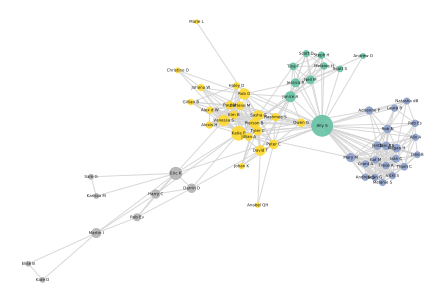

In [154]:
colors = [part[n] for n in ego.nodes()]
my_colors = plt.cm.Set2

pos = nx.spring_layout(ego, iterations=500, seed = 13)

nx.draw(ego, 
        pos = pos, 
        with_labels = True, 
        font_color = 'black', 
        font_size = 4, alpha = .9,
        node_size = [s*800 + 15 for s in centralities['Current Flow Betweenness']],
        node_color=colors, 
        cmap = my_colors, 
        edge_color = "lightgray")

As you can see in this visualization, the Louvain community detection did a good job of identifying distinct clusters of densely connected nodes in my personal network. And yet, there are some important limitations. Consider the node 'Ally S'. As I mentioned in the last Module, Ally is my partner, which explains her higher centrality scores -- she knows more people in my personal network than anyone else does. For the same reason she sits at the intersection of different cohesive subgroups in my network -- work at the University of Waterloo, grad school at McMaster University, and friends and family from the various places we have lived in Canada, the US, and (briefly) Italy. However, the Louvain algorithm identifies mutually exclusive communities, meaning Ally can only be assigned membership in 1 of those groups. The algorithm decided to classify her as a member of my grad school subnetwork, which consists of faculty and former students from McMaster, including Tina Fetner, who supervised Ally's PhD dissertation. In short, it makes sense to classify Ally as a member of that community, but substantively, it would make just as much sense to classify her as a member of the community made up of our family members and friends, or even our network of friends, colleagues, and students from University of Waterloo. 

Another observation (which is obvious to me but would not be obvious to you) is that the communities identified in this network are strongly shaped by geography. The blue nodes on the top left are mostly people who are from St. John's (some of whom still live there, some of whom do not). The green cluster are mostly people from grad school, most of whom live in Hamilton or other parts of the greater Toronto area. The yellow nodes at the bottom are mostly people from Kitchener-Waterloo, and nearly all of them are connected in some way to the University of Waterloo. Finally the gray nodes, which are more loosely connected, include two groups of people. At the top is a group of collaborators from Cardiff University and two collaborators from other universities who work with some of the same people. Connected to Eric K are two people I became good friends in a program called [Science Outside the Lab](https://sotlnorth.weebly.com/about-sotl-north.html) that I co-run with Eric K in Ottawa, Montréal, and Vancouver. The grouping of these nodes together reflect a second limitation of the Louvain community detection algorithm: it is not especially good at differentiating small communities, especially if they don't have a lot of dense local ties. 

Sometimes it is useful to bump things up a level of analysis, such as by looking at networks of cohesive subgroups rather than networks of individuals who cluster into groups. This aggregation approach offers a slightly different perspective on network structure. It is also a highly effective strategy for addressing problems associated with large and complex networks, although *it's applications are much more general than that*. 

Once you have detected communities with the Louvain algorithm, you can then aggregate the communities into single nodes and assign edges to them when a node from one community has a tie to a node in another community. This can be by simply passing the Louvain partitions and the network object to the `induced_graph()` function from the `community` package. 

By the way, the code below runs quickly on our data, but it will take a while to run on a large network. If you decide to run it on a large network, steep some tea while you wait for it to finish! ☕️ 

In [155]:
inet = community.induced_graph(part, ego)
inet.name = "Induced Ego Network"
print(nx.info(inet))

Name: Induced Ego Network
Type: Graph
Number of nodes: 4
Number of edges: 9
Average degree:   4.5000


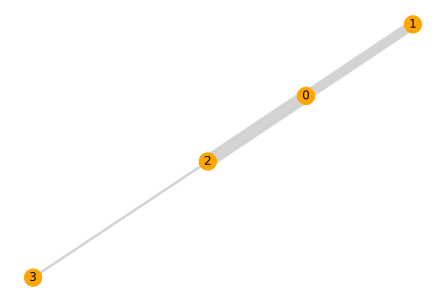

In [156]:
weights = [inet[u][v]['weight'] / 2 for u,v in inet.edges()]
ipos = nx.spring_layout(inet, iterations=50, seed = 13)

nx.draw(inet, 
        node_color = 'orange',
        pos = ipos,
        with_labels = True, 
        font_color = 'black', 
        font_size = 12, 
        width=weights,
        edge_color = "lightgray")

Let's look up the names of the nodes in these communities to help figure out what's going on in this aggregated view of the network. 

In [157]:
mc = 2
for k,v in part.items():
    if v == mc:
        print(k)

Owen G
Rashmee S
Rob G
Katie P
Vanessa S
Peter C
Pierson B
Sasha G
Tyler C
Jillian A
David T
Haley D
Kim B
Paul M
Darlene M
Alexis H
Alex d W
Johana W
Christine D
Marie L
Gillian B
Anabel QH
Johan K


As expected, this view of the network is showing dense connections between my colleagues and students at the University of Waterloo (MC2), my friends and colleagues from McMaster University (MC0), and my closest friends from outside university life (MC1). The last community (MC3) are mostly part of my collaborators based on or also affiliated with Cardiff University, but with a few other people who really should be in their own community. 

In sum, then, the Louvain algorithm is very good but has two primary limitations, both of which are reflected in the analysis of my own ego network: (1) nodes must belong to one and only one community because communities can't overlap, and (2) small communities may not be accurately identified and may end up being merged into larger communities. The next methods we will cover for community detection do not have these limitations. They can detect small communities, and they can allow communities to overlap by virtue of nodes having multiple membership. 

### <font color="green">YOUR TURN! (Question 1)</font> <a id='yt1'></a>

Question is Worth: <font color="green">1 point</font>

In the cell below, use `best_partition()` to use the Louvain method to detect communities in *your* ego network. Then visualize the network using colors to differentiate between communities in the network. In other words, produce a visualization similar to one I developed to show the structure of communities in my ego network. This part of the question is worth .5 points. 

Then, in the cell below that, produce a visualization of the aggregated / induced network where the nodes are the communities from your ego network. This part of the question is worth .5 points. 

The modularity of the network is 0.566.


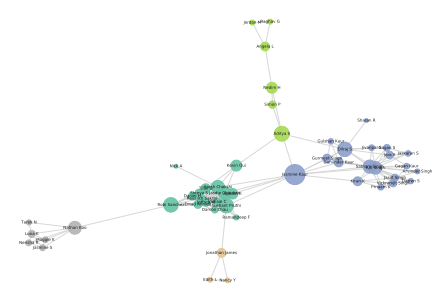

In [158]:
# Your Answer Here (Part A worth .5 points)
ego_stu.add_edge('Robi Sanchez', 'Nathan Koo')
part_stu = community.best_partition(ego_stu)
print("The modularity of the network is {}.".format(np.round(community.modularity(part_stu, ego_stu), 3)))

colors = [part_stu[n] for n in ego_stu.nodes()]
my_colors = plt.cm.Set2

pos_stu = nx.spring_layout(ego_stu, iterations=500, seed = 13)

nx.draw(ego_stu, 
        pos = pos_stu, 
        with_labels = True, 
        font_color = 'black', 
        font_size = 4, alpha = .9,
        node_size = [s*800 + 15 for s in centralities_stu['Current Flow Betweenness']],
        node_color=colors, 
        cmap = my_colors, 
        edge_color = "lightgray")

Name: Induced Ego Network
Type: Graph
Number of nodes: 5
Number of edges: 10
Average degree:   4.0000


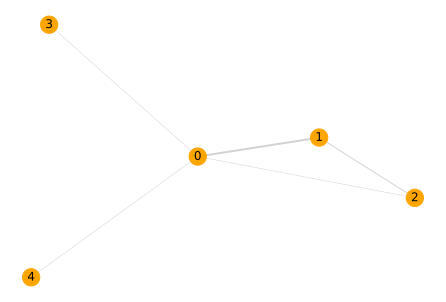

In [159]:
# Your Answer Here (Part B worth .5 points)
inet_stu = community.induced_graph(part_stu, ego_stu)
inet_stu.name = "Induced Ego Network"
print(nx.info(inet_stu))

weights_stu = [inet_stu[u][v]['weight'] / 2 for u,v in inet_stu.edges()]
ipos_stu = nx.spring_layout(inet_stu, iterations=50, seed = 13)

nx.draw(inet_stu, 
        node_color = 'orange',
        pos = ipos_stu,
        with_labels = True, 
        font_color = 'black', 
        font_size = 12, 
        width=weights_stu,
        edge_color = "lightgray")

### <font color="green">YOUR TURN! (Question 2)</font> <a id='yt2'></a>

Question is Worth: <font color="green">1 point</font>

In the cell below, interpret the results of the Louvain community detection analysis on your own personal network. Who are the various communities in the network? Who did it do a good job of classifying and who did it do a poor job of classifying?

In [225]:
for k,v in part_stu.items():
    print(v,k)

0 Jasdip Chauhan
1 Jasmine Kaur
0 Kevin Qui
0 Sushant Pruthi
0 Emad Ahmed
0 Harsh Chokshi
0 Tilak G
0 Shreya S
0 Revanth Sakthi
0 Daniel H
0 Damon Chau
0 Jeffrey W
0 Ramandeep F
0 Vishaal C
0 Apiram K
0 Robi Sanchez
1 Satnam Singh
1 Ajit Singh
1 Gurmeet Singh
1 Gurvinder Kaur
1 Kiran K
2 Aditya S
1 Dilraj S
1 Gagan Kaur
1 Vickramjit Singh
1 Jora S
1 Jasjit Singh
1 Arvinder Singh
1 Jivanpal S
1 Prnaam K
1 Darren S
1 Gagan S
1 Jaskaran S
1 Gulshan Kaur
3 Jonathan James
0 Nick A
2 Angela L
2 Raghav G
2 Jordan M
2 Nedim H
2 Simon P
4 Nathan Koo
4 Luna K
4 Maggie K
4 Jasmine S
4 Nerisha R
4 Tarek N
3 Nancy Y
3 Edith L
1 Sharan R


The induced ego network tends to show communities that are fairly distinct with those being: 
> 0. Program Friends
> 1. Friends outside of school and similar in my religious beliefs
> 2. Friends from my high school 
> 3. Frirnds from work 
> 4. Friends and club teammates from the club I'm part of this year 

Some of my family is tied into community 1 but it would be interesting to see if smaller communities could be identified to see them within a separate community of their own. It's pretty accurate how my high school friends and school friends have been accurately identified. One key obsercation has been how Jasmine has been idenitified outside my school friends and more so with my other outside friends when I often interact with her in school most of the time. Within the induced ego network, the communities all look distinct with very little weight in their edges while program and outside school friends are the only ones that are more stronger intertwined.  

### The Drug Use Network

So far we have only looked at the data for your personal network. Recall that we also loaded up a network of people who are connected to each other by injecting drugs or using crack together. That network is saved in the `networkx` object `G`. In this section and for most of the rest of the Module, we will switch our focus over to the drug use network. We will still analyze your personal network data, but it will be secondary to the analysis of the drug using network. 

Before we get started working on detecting subgroups in this data, let's produce a visualization of the network. We will produce others throughout the notebook that are based on this initial visualization. 

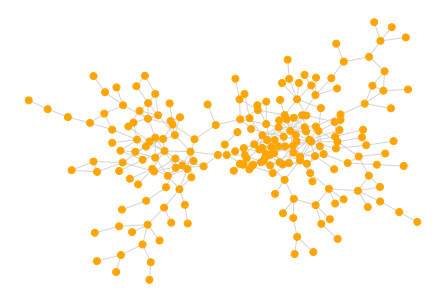

In [160]:
drug_pos = nx.kamada_kawai_layout(G)

nx.draw(G, 
        pos = drug_pos, 
        with_labels = False, 
        node_color = 'orange', 
        font_color = 'black', 
        edge_color = 'lightgray', 
        font_size = 4, 
        node_size = 50)

## $k$-Clique Communities <a id='kcc'></a>

The assigned readings -- especially the chapter by John Scott -- emphasize the importance of cliques. Before we get into this topic, **here's something to keep in mind**: a $k$-clique is not the same thing as an $n$-clique or a $k$-plex, both of which Scott discusses. The method we are discussing here is very close to the discussion of Kadushin and Alba's work on "overlapping social circles," which is discussed in Scott's chapter towards the bottom of page 116. The concept of "overlapping social circles" originally comes from the sociologist Georg Simmel's (1922 [1955]) *Conflict and the Web of Group Affiliations*, which was first published in German in 1908. Simmel is generally considered one of the forerunners of structural analysis and social network analysis in the social sciences. 

Recall that a clique is a set of nodes that is *completely* connected: every node is connected to every other node. As this is the only requirement, cliques can vary in sizes. However, they tend not to be especially large, since most real social networks are fairly sparse and having all nodes be connected to all other nodes is a rather high bar. The $k$-clique is a variation on this idea, where $k$ is the number of nodes in the clique. For example, if $k$ = 5, we want to find all groups of 5 nodes where each node in the set of 5 is connected to all other nodes. If 4 of the 5 nodes are completely connected but the fifth node is missing a connection to one of the other nodes, it is *not* a 5-clique, it's a 4-clique. 

As previously mentioned, cliques tend to be fairly small in real world social networks. The $k$-clique communities approach to detecting cohesive subgroups in a social network is based on the idea that communities are based on collections of overlapping cliques. Those resulting communities can *also* overlap. This basic idea -- overlapping communities composed over over-lapping $k$-cliques -- is an extremely appealing one because it more realistic and valid than alternative approaches that require nodes to be members of only one community, such as Louvain. 

The question, then, is how to determine when cliques sufficiently overlap to be considered a 'community.' Following Palla et al. (2005), we will say that $k$-cliques are "adjacent" / overlapping when they share at least $k-1$ nodes. In other words, if we say $k = 4$, then we find 4-cliques in the network. If another clique shares 3 nodes ($k = 4$ so $k - 1 = 3$), they are adjacent $k$-cliques. Those two cliques are then merged into one community. This process continues until there are no more adjacent cliques. 

Detecting cliques can be very computationally intensive, especially for large networks. Fortunately there are variations on the basic idea that make it possible to do this type of analysis on larger and more complex graphs. The most common approach is the clique percolation method. In short, clique percolation works by: 

1. finding all the maximal cliques in a network 
2. creating an adjacency matrix where the cells represent the number of nodes shared by two cliques 
3. thresholding the matrix using the value $k - 1$ so as to prevent merging cliques that overlap but below the $k - 1$ threshold
4. forming communities from the connected components that remain after thresholding

This clique percolation method is implemented in `networkx` and is used when we run the `k_clique_communities()` function. Note that `k_clique_communities()` is not implemented in the top-level `networkx` namespace, so we imported the function on it's own at the start of this Module notebook. 

Let's do a $k$-clique communities analysis of the drug using network. One thing to keep in mind when we do so is that higher values of $k$ will result in a smaller number of cliques identified because large cliques are rare. Small values of $k$ will result in more cliques detected because small cliques are more common. 

In [161]:
ccs = list(k_clique_communities(G, k=3))
print('Identified {} 3-clique communities.'.format(len(ccs)))

Identified 22 3-clique communities.


If we set $k = 3$, we find 22 clique communities in the graph. We can easily print the node IDs for each of the 22 communities by iterating over the lists produced by the code in the previous cell. The node IDs in this network are numerical to protect the anonymity of participants in the study. 

In [162]:
communities = [list(c) for c in ccs]
communities

[[1, 2, 9, 10],
 [64, 17, 78],
 [19, 92, 30],
 [64, 20, 22, 23],
 [180, 20, 58],
 [24, 122, 31],
 [43, 34, 35],
 [80, 210, 38, 207],
 [182, 190, 38],
 [64, 50, 70],
 [50, 67, 55],
 [208, 50, 197, 58, 188, 30],
 [210, 54, 111],
 [74, 75, 215],
 [103, 104, 58, 76, 77],
 [89, 90, 94],
 [128, 121, 111],
 [129, 118, 138, 191],
 [146, 148, 165, 169, 171],
 [192, 149, 167],
 [218, 222, 198],
 [234, 68, 230]]

Remember, the idea here is that communities are *overlapping*, so we should see some nodes that appear in multiple communities. Let's create a new `dictionary` where the keys are node IDs and the values are a list of the $k$-clique communities that a node is embedded in. If a node is not part of any $k$-clique communities, we will leave their list empty. We will just use numerical IDs (derived from the index in the outer list) for the community IDs. The numbers themselves do not have any meaning, they are just numerical IDs. 

In [163]:
kccs = {}
for node in G.nodes():
    kcliques = [communities.index(c) for c in communities if node in list(c)]
    kccs[node] = kcliques
# kccs

We can print the list of overlapping nodes by simply checking for keys in the `dictionary` that have more than 1 $k$-clique community. We will also create another list that includes the node IDs for all nodes that are embedded in *any* $k$-clique component. This list can be used to determine the percentage of nodes in the network that are part of a community. We will also use it in a network visualization below. 

In [164]:
overlapping_nodes = []
in_any_kclique = []

for k,v in kccs.items():  
    if len(v) > 1:
        overlapping_nodes.append(k)
    if len(v) >= 1:
        in_any_kclique.append(k)

print('There are {} nodes that belong to multiple k-clique communities: {}.'.format(len(overlapping_nodes), overlapping_nodes))
print('There are {} nodes ({}% of the network) that are embedded in at least one k-clique community.'.format(len(in_any_kclique), np.round(len(in_any_kclique)/len(G), 2)*100))

There are 8 nodes that belong to multiple k-clique communities: [64, 20, 30, 38, 210, 50, 111, 58].
There are 66 nodes (31.0% of the network) that are embedded in at least one k-clique community.


Again, let's use some network visualization to help understand these results. This time, let's construct a visualization where all nodes and edges are initially gray. Then we will overlay a visualization (using the same layout coordinates) of the nodes that are embedded in at least one $k$-clique component in orange. Next, we will emphasize the subset of nodes who are embedded in multiple communities by plotting them as blue squares. Next we will overlay a visualization of the *edges* that connect pairs of nodes in $k$-clique communities in orange. Finally, we will print labels for nodes indicating the numerical ID of the community they are embedded in. We will not do so for nodes in more than one community in order to keep the visualization clean and readable. 

To do all of this, we need to do a little bit of prep work. Specifically, we need to get a list of tuples for the edges embedded in $k$-clique communities, and we need to get the community IDs for nodes that are embedded in 1 community. We will also use the lists `overlapping_nodes` and `in_any_kclique` in our visualization, but they have already been created so we don't need to do anything further. 

In [165]:
edges_in_kcliques = [e for e in G.edges() if e[0] in in_any_kclique and e[1] in in_any_kclique]
# edges_in_kcliques # this is a list of tuples, which networks can use to plot in the `draw_networkx_edges()` function.

In [166]:
labs = {}
for k,v in kccs.items():  
    if len(v) is 1:
        labs[k] = v[0]

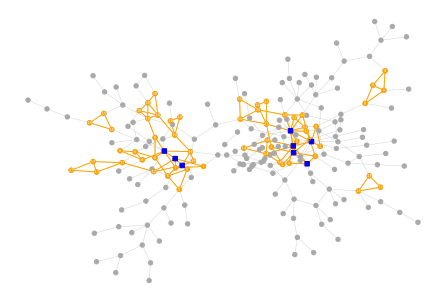

In [167]:
nx.draw(G, drug_pos, with_labels = False, node_color = 'darkgray', edge_color = 'lightgray', node_size = 20, width = .5)
nx.draw_networkx_nodes(G, drug_pos, node_size = 20, node_color = 'orange', with_labels = False, nodelist = in_any_kclique)
nx.draw_networkx_nodes(G, drug_pos, node_size = 20, node_color = 'blue', node_shape = 's', with_labels = False, nodelist = overlapping_nodes)
nx.draw_networkx_edges(G, drug_pos, edge_color = 'orange', edgelist = edges_in_kcliques)
labs = nx.draw_networkx_labels(G, drug_pos, labels = labs, font_size = 3.5, font_color = 'white')

The visualization we just produced 

1. highlights the nodes that straddle multiple communities in blue, 
2. highlights the nodes and edges that are part of *any* $k$-clique community in orange, and 
3. provides the community ID as a label for any node that is embedded in 1 $k$-clique community. 

Now it's time to test your understanding of this method of community detection. 

### <font color="green">YOUR TURN! (Question 3)</font> <a id='yt3'></a>

Question is Worth: <font color="green">1 point</font>

The majority of the nodes in this network are *not* part of a $k$-clique community. Why not? How are they different than the nodes in the network that *are* part of a community? 

Majority of the nodes in this network are not part of a K-clique community since they can't be included in a set of three nodes to which they're interconnected to all other nodes. Due to not meeting this criteria, they're highlighted as grey nodes which implies they don't belong to a community in relation to the size of our interest. Within the context of the analysis, this means that there are some individuals who are not related in communities of three where there is a distribution of crack or drug injection. These nodes tend to be different since there is more of a dependency/relation/knowledge tied to groups is disparate and less than the allotted group of 3. 

## Components and $k$-Cores <a id='kcores'></a>

The method we just covered starts from small cohesive groups -- $k$-cliques -- and works up to larger communities by merging adjacent $k$-cliques. Now we are going to switch our focus to another set of approaches that work the opposite way: from the top down. The first thing we need to do is discuss components. 

### Components

The Scott and Kadushin readings emphasize the substantive importance of components, especially when it comes to communication and diffusion processes. Detecting and describing components is straightforward in `networkx`, and the [documentation](https://networkx.github.io/documentation/stable/reference/algorithms/component.html) describes many additional functions implementing the methods described in John Scott's chapter. Most are not applicable in this case, however, because the networks we are analyzing are undirected. 

To illustrate the use of some of these methods, let's analyze our drug use network (which has multiple components). We will begin by determining how many components there are in the overall network. We will do this using the `number_connected_components()` function, which takes a network as an argument. 

In [168]:
comps = nx.number_connected_components(G)
print('There are {} components in the drug use network.'.format(comps))

There are 9 components in the drug use network.


How many nodes are in each of those 9 components? 

In [169]:
comps_sizes = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
comps_sizes

[193, 3, 3, 3, 2, 2, 2, 2, 2]

The largest component in this network has 193 nodes. Generally, we refer to the largest component in a network as the 'giant' component. 

Many network methods require operating on a connected graph (i.e. a single component). We now know that the network we are working with here -- like many real world networks -- is not fully connected. It contains several dyads (2 nodes) and triads (3 nodes) that are disconnected from the giant component of the network. In situations like these, one option is to decompose the network into separate networks for each component and analyze the components separately. 

### $k$-Cores

The subsection "The Contours of Components" in the assigned chapter by John Scott introduces the idea (which we will pick up again later in this module) that components are inherently **nested**. Think of a [Russian nested doll](https://www.google.com/search?q=nested+Russian+doll&client=safari&rls=en&sxsrf=ACYBGNR5DpYvF4lEYKCGVrr-R3VhbLO-Mg:1576688750901&source=lnms&tbm=isch&sa=X&ved=2ahUKEwihr6yn17_mAhWCrVkKHavtDXAQ_AUoAXoECAwQAw&biw=2560&bih=1377), where small dolls are nested inside bigger dolls. Similarly, components have small components within them, each more densely connected. At the *core* of a component is a set of densely connected nodes. As you progress away from that densely connected core, you have nodes that are less densely connected. At each step out, the component is *less cohesive*. The component itself is the least cohesive grouping of nodes where all nodes are still connected and are at least reachable indirectly (e.g. along paths involving intermediary nodes). 

$k$-cores are one of the most common ways of identifying the cohesive groups of nodes at the core of a component. In this approach, $k$ represents a minimum degree value. For example, if $k$ = 5, then the $k$-core will consist of nodes who have a degree of at least five. In other words, it will return a maximal subgraph where each node is connected to at least 5 other nodes. A 'component' itself is $k$ = 1, since the only requirement is that all nodes be connected directly or indirectly. A $k$ = 2 $k$-core would be the nodes within that component that are connected to at least two other nodes. As the value of $k$ increases, denser and more cohesive regions of the component are revealed. Such an analysis could reveal pockets of dense connections which are themselves only weakly connected. 

Let's extract a series of $k$-cores from the drug using network (`G`) and compare some simple descriptives. 

In [170]:
ks = [1,2,3,4]
nnodes = []
nedges = []

for k in ks:
    kcore = nx.k_core(G, k)
    nnodes.append(kcore.number_of_nodes())
    nedges.append(kcore.number_of_edges())
    
kdf = pd.DataFrame([ks,nnodes,nedges]).T
kdf.columns = ['Value of K', 'Number of Nodes', 'Number of Edges']
kdf

,Value of K,Number of Nodes,Number of Edges
0,1,212,284
1,2,115,195
2,3,23,40
3,4,0,0


We can see here that the full giant component is represented when $k$ = 1, but we also retain the dyads and triads. If there were isolates in this network, they would have been dropped. The number of nodes and edges in the network drops considerably with $k$ = 2, and then there is a massive drop in size for $k$ = 3. There are no nodes or edges that are retained for $k$ >= 4 in this particular network. 

Let's see what the $k$-cores look like for $k=2$ and $k=3$. To do so, we will extract the $k$-core subgraph and then visualize the $k$-core. To simplify interpretation, we will use the same layout coordinates that we used in the original visualizations of the drug using network [earlier in the Module](#drug_vis).

In [171]:
kcore_2 = nx.k_core(G, 2)
kcore_3 = nx.k_core(G, 3)

Text(0.5, 1.0, '$k$-core ($k=2$)')

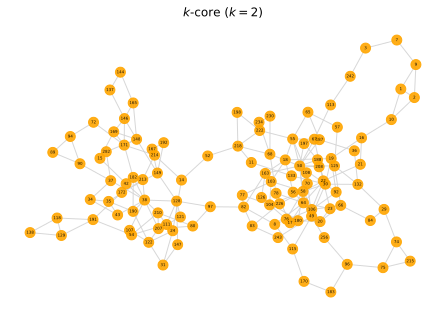

In [172]:
nx.draw(kcore_2, pos = drug_pos,
        with_labels = True, 
        node_color = 'orange', 
        font_color = 'black', 
        edge_color = 'lightgray', 
        font_size = 4, alpha = .9, 
        node_size = 100)
plt.title('$k$-core ($k=2$)')

Text(0.5, 1.0, '$k$-core ($k=3$)')

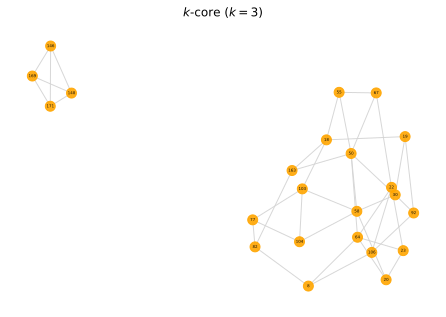

In [173]:
nx.draw(kcore_3, pos = drug_pos,
        with_labels = True, 
        node_color = 'orange', 
        font_color = 'black', 
        edge_color = 'lightgray', 
        font_size = 4, alpha = .9, 
        node_size = 100)
plt.title('$k$-core ($k=3$)')

Finally, to emphasize the *nestedness* of these $k$-cores, let's layer these visualizations. In the graph below, we first draw our base graph, with all nodes and edges in the giant component in light gray. Then we overlay a visualization of the 2-core using the same layout coordinates, but coloring the nodes and edges orange. Finally, we overlay a visualization of the 3-core, again using the same layout coordinates by coloring the nodes and edges blue. The resulting visualization shows how the most locally dense regions of the network are embedded in larger and less cohesive regions of the network, *much like the Russian nested dolls previously mentioned*. 

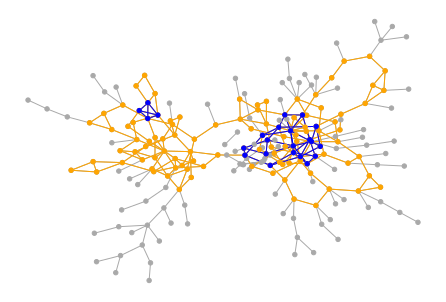

In [174]:
# draw the base graph
nx.draw(G, drug_pos, with_labels = False, node_color = 'darkgray', edge_color = 'darkgray', node_size = 20)
# draw the nodes in the 2-core orange
nx.draw_networkx_nodes(kcore_2, drug_pos, node_size = 20, node_color = 'orange', with_labels = False)
nx.draw_networkx_edges(kcore_2, drug_pos, node_size = 20, edge_color = 'orange', with_labels = False)
# draw the nodes in the 3-core in blue
nx.draw_networkx_nodes(kcore_3, drug_pos, node_size = 20, node_color = 'blue', with_labels = False)
nx.draw_networkx_edges(kcore_3, drug_pos, node_size = 20, edge_color = 'blue', with_labels = False)

It is also possible to get a core number for each node in the network. For each node, the core number is equal to the largest $k$-core that node is embedded in. So the nodes in the network above that are colored blue would have a core number of 3 because they are embedded in a 3-core. The orange nodes have a core number of 2 because they are in 2-cores. All other nodes in the network have core numbers of 1 because they are only embedded in the simple component. 

To get the core numbers for nodes in the network, we can use the `core_number()` function. Like the centrality analyses we ran earlier in the notebook, this analysis will return a `dictionary` keyed by the node ID. 

In [175]:
core_numbers = nx.core_number(G)

In [176]:
core_numbers

{1: 2,
 2: 2,
 10: 2,
 3: 2,
 7: 2,
 4: 1,
 209: 1,
 5: 1,
 132: 2,
 6: 1,
 150: 1,
 9: 2,
 8: 3,
 106: 3,
 115: 2,
 11: 2,
 133: 2,
 218: 2,
 12: 1,
 88: 1,
 13: 1,
 214: 2,
 14: 2,
 24: 2,
 52: 2,
 16: 2,
 19: 3,
 17: 2,
 64: 3,
 78: 2,
 18: 3,
 55: 3,
 103: 3,
 163: 3,
 20: 3,
 180: 2,
 21: 2,
 22: 3,
 23: 3,
 31: 2,
 122: 2,
 27: 1,
 28: 1,
 29: 2,
 30: 3,
 32: 1,
 147: 2,
 233: 1,
 86: 1,
 34: 2,
 35: 2,
 37: 2,
 43: 2,
 36: 2,
 187: 2,
 38: 2,
 90: 2,
 282: 2,
 42: 2,
 210: 2,
 40: 1,
 15: 2,
 45: 1,
 107: 2,
 46: 1,
 61: 1,
 72: 2,
 48: 1,
 49: 2,
 108: 2,
 243: 2,
 50: 3,
 47: 1,
 125: 2,
 224: 1,
 54: 2,
 111: 2,
 65: 2,
 67: 3,
 105: 1,
 222: 2,
 56: 2,
 57: 2,
 58: 3,
 59: 1,
 164: 1,
 63: 1,
 70: 2,
 256: 2,
 66: 2,
 84: 2,
 113: 2,
 68: 2,
 71: 1,
 74: 2,
 75: 2,
 215: 2,
 76: 2,
 104: 3,
 77: 3,
 80: 2,
 207: 2,
 82: 3,
 83: 2,
 97: 2,
 226: 2,
 154: 1,
 87: 1,
 101: 1,
 189: 1,
 89: 2,
 94: 2,
 91: 1,
 92: 3,
 95: 1,
 96: 2,
 128: 2,
 98: 1,
 100: 1,
 114: 1,
 121: 2,
 2

Finally, to clarify things still further, we can overlay the node core numbers onto the visualization. We will do so by adding one more line of code that overlays white text labels over all nodes in the network. 

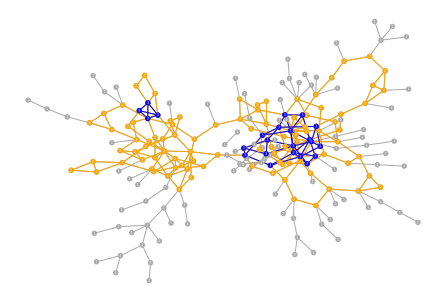

In [177]:
# draw the base graph
nx.draw(G, drug_pos, with_labels = False, node_color = 'darkgray', edge_color = 'darkgray', node_size = 20)
# draw the nodes in the 2-core orange
nx.draw_networkx_nodes(kcore_2, drug_pos, node_size = 20, node_color = 'orange', with_labels = False)
nx.draw_networkx_edges(kcore_2, drug_pos, node_size = 20, edge_color = 'orange', with_labels = False)
# draw the nodes in the 3-core in blue
nx.draw_networkx_nodes(kcore_3, drug_pos, node_size = 20, node_color = 'blue', with_labels = False)
nx.draw_networkx_edges(kcore_3, drug_pos, node_size = 20, edge_color = 'blue', with_labels = False)
# draw the labels, using core numbers as labels rather than node ID
labs = nx.draw_networkx_labels(G, drug_pos, labels = core_numbers, font_size = 3.5, font_color = 'white')

This notion of nested components and regions of local density in a network sets us up nicely for our next approach to analyzing cohesive subgroups: $k$-components and structural cohesion analysis. But first, answer the following question. 

### <font color="green">YOUR TURN! (Question 4)</font> <a id='yt4'></a>

Question is Worth: <font color="green">1 point</font>

In the cell below, 

1. use the `core_number()` to compute the node core scores for the nodes in *your* ego network, 
2. plot your ego network, and finally, 
3. overlay a plot of the $k$-core network for $k=3$. 

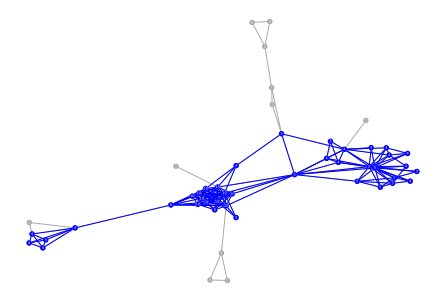

In [178]:
# Your Answer Here
core_numbers_stu = nx.core_number(ego_stu)
nx.draw(ego_stu, pos_stu, with_labels = False, node_color = 'darkgray', edge_color = 'darkgray', node_size = 20)
kcore_3_stu = nx.k_core(ego_stu, 3)
nx.draw_networkx_nodes(kcore_3_stu, pos_stu, node_size = 20, node_color = 'blue', with_labels = False)
nx.draw_networkx_edges(kcore_3_stu, pos_stu, node_size = 20, edge_color = 'blue', with_labels = False)
core_numbers = nx.core_number(ego_stu)
labs = nx.draw_networkx_labels(ego_stu, pos_stu, labels = core_numbers, font_size = 3.5, font_color = 'white')


### <font color="green">YOUR TURN! (Question 5)</font> <a id='yt5'></a>

Question is Worth: <font color="green">1 point</font>

In the cell below, interpret the results of the $k$-core analysis on *your* ego network. 

Within this visualization, it can be seen that there is a large density in the network of students that are in my program implying the dense connectivity and cohesion among the group. While there are some components that range on a rather less cohesive end with close to 4 nodes of connection among each other. It goes, program friends, Jasmine, outside-school friends, BC friends, Club friend in that order that go from the highest to lowest in relative cohesion. Interestingly, all the components with >3 are all somehow connected to one another. 

## $k$-Components and Structural Cohesion <a id='sce'></a>

As previously mentioned, another powerful approach to analyzing the subgroup structure of a network is structural cohesion analysis, which as you might guess, emphasizes *structural cohesion*. 🤯 Or, to put it another way, it focuses on how networks hold together or break apart as nodes are strategically removed. Like other methods we have just discussed, structural cohesion analysis is based on the idea that more cohesive subgroups are nested inside less cohesive subgroups (see the middle of page 103 in the Scott chapter). Once again, Russian nested dolls are a good analogy here. 

The idea of a $k$-component is central to structural cohesion analysis. Imagine you have a component with 42 nodes in it. Who would you have to remove from this network to break it's connectivity? In other words, to break the single component into two components? Well, let's say you run an algorithm that identifies 7 nodes that you would have to remove from the network in order to break connectivity. Because we would have to remove 7 nodes to break the component into 2 components, we call our component a 7-component. The more general idea of the $k$-component, as you can probably guess, is that every component has some number of nodes that, if removed, would disconnect it. That number is represented by $k$. 

A structural cohesion analysis starts with the whole network and identifies the nodes that would have to be removed to disconnect the a component. Each step in the analysis repeats this process, progressing deconstructing components and revealing a nested hierarchy of cohesive subgroups, each labeled by the value of $k$ that separated it from the larger less cohesive component it was previously embedded in. 

Structural cohesion analysis can *also* determine how embedded a node is in a network. It does so by assigning an embeddedness score that is equal to the deepest $k$-component that a node is in. For example, if a node is embedded in a 9-component, it would have an embeddedness of 9. A node embedded only in a 3-component would have an embeddedness of 3. Remember, as we dig deep into a network, we are uncovering subgroups that are increasingly cohesive. Each of those cohesive subgroups, and each node within, are *also* embedded in less cohesive subgroups. So our node with an embeddedness score of 9 is embedded in a 9-component, but also 8, 7, 6, 5, 4, 3, 2 (bi-), and 1 (simple) components. 

It's a beautiful idea, but it's pretty abstract. Let's make it more concrete with an application. 

The key `networkx` function for a structural cohesion analysis is `k_components()`. It returns a `dictionary` of `lists` of `sets`, where the `dict` key is $k$ and the `list` of `sets` are nodes in that $k$-component. This algorithm can take some time to run, so if you running it on a larger network be prepared to wait a while. 

In [179]:
kc = nx.k_components(G)
# kc # a lot to print to screen! 

We can iterate over this nested data structure (remember, a `dict` of a `list` of `sets`) to print the node IDs that belong to each $k$-component.

In [180]:
for k, v in kc.items():
    print("Nodes in {}-component:".format(k), list(v[0]))
    print('\n')

Nodes in 2-component: [129, 138, 118, 191]


Nodes in 1-component: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 42, 43, 45, 46, 47, 48, 49, 50, 52, 54, 55, 56, 57, 58, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 80, 82, 83, 84, 86, 87, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 111, 113, 114, 115, 116, 118, 121, 122, 123, 124, 125, 126, 128, 129, 132, 133, 134, 135, 137, 138, 140, 141, 143, 144, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 161, 163, 165, 167, 169, 170, 171, 172, 173, 175, 176, 180, 182, 183, 185, 187, 188, 189, 190, 191, 192, 195, 197, 198, 200, 201, 202, 203, 206, 207, 208, 209, 210, 211, 213, 214, 215, 218, 220, 221, 222, 224, 225, 226, 229, 230, 231, 232, 233, 234, 237, 242, 243, 244, 249, 250, 252, 253, 254, 256, 258, 268, 270, 272, 275, 280, 282, 285, 290, 293]




As you likely already suspected based on our previous analyses, the drug use network is not very structurally cohesive. The most deeply embedded nodes are only embedded in a bi-component ($k=2$), and there are only four of them. 

For comparison, let's run the algorithm on my personal network. 

In [181]:
kc = nx.k_components(ego)
# kc # a lot to print to screen! 

In [182]:
for k, v in kc.items():
    print("Nodes in {}-component:".format(k), list(v[0]))
    print('\n')

Nodes in 12-component: ['Sean G', 'Megan H', 'Jen D', 'Andrew S', 'Ally S', 'Melanie S', 'Grant A', 'Dom RB', 'Kat M', 'Ivan C', 'Mary M', 'Trese A', 'Vicki S']


Nodes in 11-component: ['Sean G', 'Megan H', 'Jen D', 'Andrew S', 'Ally S', 'Melanie S', 'Grant A', 'Dom RB', 'Kat M', 'Ivan C', 'Mary M', 'Trese A', 'Vicki S']


Nodes in 10-component: ['Sean G', 'Megan H', 'Jen D', 'Andrew S', 'Ally S', 'Melanie S', 'Grant A', 'Dom RB', 'Kat M', 'Ivan C', 'Thom C', 'Mary M', 'Trese A', 'Vicki S']


Nodes in 9-component: ['Jillian A', 'Kim B', 'Ally S', 'Pierson B', 'Vanessa S', 'Alex d W', 'Alexis H', 'Rob G', 'Darlene M', 'Tyler C', 'Paul M', 'Katie P', 'Sasha G']


Nodes in 8-component: ['Sean G', 'Jane B', 'Andrew S', 'Ally S', 'Melanie S', 'Rob N', 'Ivan C', 'Thom C', 'Megan H', 'Jen D', 'Grant A', 'Dom RB', 'Kat M', 'Mary M', 'Alix A', 'Trese A', 'Vicki S']


Nodes in 7-component: ['Ally S', 'Pierson B', 'Janice A', 'David T', 'Peter C', 'Tyler C', 'Paul M', 'Katie P', 'Sasha G', 'Jill

As you can see, the results can be rather different in a more structurally cohesive network. 

In the cell below, I have written a function that uses the output of the `k_components` function in `networkx` to determine how embedded a node is in a given network. Take a moment to review the code in the function and inspect the output. Then inspect the visualization, which sizes and labels nodes based on their embeddedness score. Note that we are using my personal network data again here. 

In [183]:
def get_embeddedness_score(network, kcomp):
    """
    Accepts a network and the output of the `k_components` function in `networkx`.
    Outputs a dict of embeddedness scores, where the keys are node IDs and the values are
    embeddedness scores.
    """
    kcs = {}
    for node in network.nodes():
        comps = []
        for k,v in kcomp.items():
            if node in list(v[0]):
                comps.append(k)
        kcs[node] = max(comps, default=0) # this fixes the strange issues with 4 120 students and the max empty sequence error
    return kcs

In [184]:
es = get_embeddedness_score(ego, kc)
es

{'Ally S': 12,
 'Megan H': 12,
 'Ivan C': 12,
 'Alix A': 8,
 'Thom C': 10,
 'Rob N': 8,
 'Laura B': 6,
 'Owen G': 7,
 'Rashmee S': 7,
 'Rob G': 9,
 'Katie P': 9,
 'Vanessa S': 9,
 'Peter C': 7,
 'Pierson B': 9,
 'Sasha G': 9,
 'Tyler C': 9,
 'Jillian A': 9,
 'David T': 7,
 'Adrienne P': 6,
 'Rob Es': 6,
 'Steph H': 5,
 'Scott S': 5,
 'Jen D': 12,
 'Dom RB': 12,
 'Trese A': 12,
 'Grant A': 12,
 'Mary M': 12,
 'Kat M': 12,
 'Melanie S': 12,
 'Andrew S': 12,
 'Vicki S': 12,
 'Sean G': 12,
 'Jane B': 8,
 'Eric K': 3,
 'Janice A': 7,
 'Jessica R': 5,
 'Andrew O': 1,
 'Haley D': 5,
 'Kim B': 9,
 'Paul M': 9,
 'Darlene M': 9,
 'Neil M': 5,
 'Tina F': 5,
 'Scott D': 5,
 'Melanie H': 5,
 'Natasha dB': 6,
 'Alexis H': 9,
 'Alex d W': 9,
 'Johana W': 5,
 'Christine D': 3,
 'Marie L': 1,
 'Darrin D': 3,
 'Harry C': 3,
 'Gillian B': 5,
 'Anabel QH': 1,
 'Johan K': 5,
 'Rob Ev': 3,
 'Martin I': 3,
 'Elise B': 1,
 'Kate D': 1,
 'Sam G': 2,
 'Karissa M': 2}

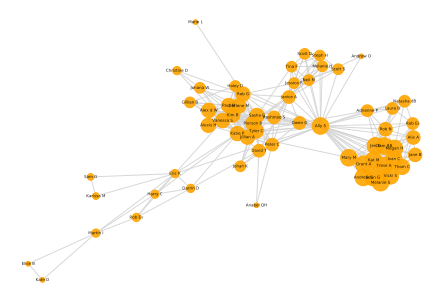

In [185]:
nx.draw(ego, 
        pos = pos, 
        with_labels = True, 
        node_color = 'orange', 
        font_color = 'black', 
        edge_color = 'lightgray', 
        font_size = 4, alpha = .9, 
        node_size = [s*23 for s in es.values()])

Let's add the embeddedness scores to our centralities `dataframe`. We will come back to it later. 

In [186]:
centralities['embeddedness'] = es.values()
centralities.sample(10)

,Degree,Eigenvector,Betweenness,Node ID,Current Flow Betweenness,Constraint,embeddedness
45,0.098361,0.066774,0.000337,Natasha dB,0.027332,0.310847,6
19,0.131148,0.092357,0.001244,Rob Es,0.034299,0.242784,6
20,0.131148,0.056803,0.000328,Steph H,0.033846,0.347856,5
42,0.131148,0.063540,0.001624,Tina F,0.039463,0.297299,5
33,0.147541,0.050077,0.172381,Eric K,0.164662,0.232215,3
59,0.032787,0.000359,0.000000,Kate D,0.010929,0.922500,1
22,0.278689,0.205406,0.005185,Jen D,0.053878,0.189236,12
55,0.081967,0.042850,0.000000,Johan K,0.016293,0.325921,5
36,0.032787,0.029933,0.000000,Andrew O,0.010444,0.569877,1
53,0.098361,0.050848,0.000000,Gillian B,0.019216,0.318389,5


### <font color="green">YOUR TURN! (Question 6)</font> <a id='yt6'></a>

Question is Worth: <font color="green">1 point</font>

In the cell below, conduct a structural cohesion and embeddedness analysis of *your* ego network. You do not need to produce a visualization of the network, but be sure to provide a ranked list of the most embedded nodes, and be sure to add the embeddedness scores to the `centralities` dataframe for your ego network. 

In [187]:
# Your Answer Here 
kc_stu = nx.k_components(ego_stu)
es_stu = get_embeddedness_score(ego_stu, kc_stu)
centralities_stu['embeddedness'] = es_stu.values()
{k: v for k, v in sorted(es_stu.items(), key=lambda item: item[1])}

{'Gurmeet Singh': 1,
 'Gurvinder Kaur': 1,
 'Aditya S': 1,
 'Dilraj S': 1,
 'Gagan Kaur': 1,
 'Jora S': 1,
 'Arvinder Singh': 1,
 'Jivanpal S': 1,
 'Darren S': 1,
 'Gagan S': 1,
 'Jaskaran S': 1,
 'Gulshan Kaur': 1,
 'Jonathan James': 1,
 'Nick A': 1,
 'Angela L': 1,
 'Raghav G': 1,
 'Jordan M': 1,
 'Nedim H': 1,
 'Simon P': 1,
 'Nancy Y': 1,
 'Edith L': 1,
 'Sharan R': 1,
 'Tarek N': 2,
 'Jasmine Kaur': 3,
 'Kevin Qui': 3,
 'Ramandeep F': 3,
 'Nathan Koo': 4,
 'Luna K': 4,
 'Maggie K': 4,
 'Jasmine S': 4,
 'Nerisha R': 4,
 'Satnam Singh': 5,
 'Ajit Singh': 5,
 'Kiran K': 5,
 'Vickramjit Singh': 5,
 'Jasjit Singh': 5,
 'Prnaam K': 5,
 'Jasdip Chauhan': 8,
 'Sushant Pruthi': 8,
 'Emad Ahmed': 8,
 'Harsh Chokshi': 8,
 'Tilak G': 8,
 'Shreya S': 8,
 'Revanth Sakthi': 8,
 'Daniel H': 8,
 'Damon Chau': 8,
 'Jeffrey W': 8,
 'Vishaal C': 8,
 'Apiram K': 8,
 'Robi Sanchez': 8}

### <font color="green">YOUR TURN! (Question 7)</font> <a id='yt7'></a>

Question is Worth: <font color="green">1 point</font>

In the cell below, interpret the results of the structural cohesion and embeddedness analysis of your ego network. 

In terms of structural cohesion, there are quite a few members who're part of an 8-component implying that there is a stronger cohesion among the component there and harder to break in connectivity in their groups. While the said can be true among the student groups, as we graduate and form distance in the places we travel, I objectively see this group being weaker in some aspect. Most of my outside and highschool friends are listed on the lower end of embeddedness which is fair since they are fairly weak in cohesion among themselves. Most of the club teammates have a mid cohesion which is mainly tied to our committment to the club. If that diminishes or turnover within the club, we could see that fall lower as well.  

# Equivalence and Positional Analysis <a id='epa'></a>

So far, the analyses we have performed are all based on the foundational idea that we can partition a network into groups of nodes with more connections to one another than they do to the rest of the network. We can aggregate these clusters into larger groups using many different methods, the result using being some group of nodes that we consider to be a "community" because of the density of their connections. Although the various approaches we have considered so far differ in very important ways, they all share that basic starting point. 

A second way of clustering nodes in a network is based on identifying groups of nodes that share similar structural profiles but whom are not necessarily connected to one another. In a classic article, Lorraine and White (1971) argued that two nodes that are not connected to one another but are otherwise connected to the same set of alters are *structurally equivalent*. Structurally equivalent nodes can be clustered together into 'blocks' and the relationships between blocks carefully examined to reveal an underlying structure of positions and role relationships. Since 1971, researchers have proposed many different ways of conceptualizing equivalence in networks and refined methods for positional analysis. The general trend has been to move away from formal structural equivalence à la Lorainne and White (1971) because this degree of similarity rarely if ever exists in real world social networks. Instead, we will measure the degree of similarity between pairs of nodes in a network using well-developed measures of similarity and distance. 

In the connection- and cohesion-based cluster analyses we have performed to this point, the hypothesis is that information, ideas, beliefs, behaviours, and so on are relatively homogeneous within clusters because of selection and influence effects. Research on diffusion and contagion exemplifies this: we think and behave like the people we are the most connected to. 

Similarly, people who occupy similar structural positions in networks tend to have beharioural similarities, and yet they are not necessarily connected to one another, and depending on the definition of equivalence used they may never be connected to one another. Here, the proposed mechanisms for similarities differ. For example, it could be that equivalent people behave in similar ways because they are conforming, at least somewhat, to the expectations of social roles associated with their position. As a professor I have a similar structural connections to students as other professors that I may or may not be connected to. Like other professors, I give lectures, facilitate seminars, supervise students, publish research papers, and so on. I do this in part because that is what professors are paid to do. The students I am connected to do not do these things because it is not part of their social role. Another positional hypothesis is that people who occupy structural positions in a network face similar situations and institutional environments, and their similar behaviours are a product of responses to those shared environments rather than shared connections. Finally, it could be that people who occupy the same structural positions in networks look to or mirror the behaviours of other people who share their structural position. For example, if they are uncertain about how to behave, or what is needed for success, they may model their behaviour off of someone else who is in the same position and seems to be thriving. 

The point is that equivalence and positional analysis introduce new ways of clustering nodes in networks based on an alternative set of theoretical ideas and hypotheses. Let's see how it is done. 

There are many ways to operationalize and measure equivalence and there are many ways to execute a positional analysis that groups nodes together based on those measures. In this case, we will use a relaxed definition of equivalence based on degree of similarity in the structural profiles between all pairs of nodes ($i$,$j$) in a network. We will do this by computing the euclidean distances between all $i$,$j$ pairs of nodes in an adjacency matrix. The next step is to use this similarity analysis to assign nodes into 'blocks' of nodes that occupy similar structural positions. We will use a hierarchical clustering algorithm to do this. Finally, we will produce a network visualization that shows the relationship between blocks in the network. 

### Step 1: Produce Distance Matrix

First, we will get our data out of the `networkx` object and into an adjacency matrix. Then we will use functions in a package called `sklearn` to produce a distance matrix from the adjacency matrix. The new values in the resulting matrix will represent Euclidean distance. 

In [188]:
ego_am = nx.adjacency_matrix(ego)
distances = euclidean_distances(ego_am)

A quick visual inspection of the distance matrix suggests that there are clusters of nodes with strong similarities in their structural profiles. The next step is to assign nodes to clusters based on these similarity scores. 

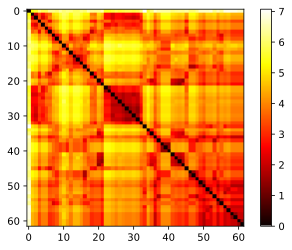

In [189]:
plt.imshow(distances, zorder=2, cmap='hot', interpolation='nearest')
plt.colorbar();

### Step 2: Cluster Nodes Based on Structural Similarity 

We will use a hierarchical clustering method to assign nodes to blocks. Each block will consist of nodes with very similar structural profiles in the network. To do so, we will use an agglomerative hierarchical clustering methods from the `scipy` package. The approach is 'agglomerative' because it starts clustering individual data points (nodes) and gradually agglomorates small clusters into larger clusters until -- at the very top level of the nested clusters -- all nodes in the network are in a single cluster. The results of this analysis will be displayed a tree diagram called a dendrogram. We will use that dendrogram to help make a decision about where in the hierarchical tree of nested clusters we want to stop and make a decision about how inclusive or exclusive the clusters are. 

To compute the linkages between nodes in the adjacency matrix, we will use the `linkage` method from `scipy`'s `hierarchy` class.

In [190]:
Z = hierarchy.linkage(distances, 'ward') # you can also use methods other than ward, such as single, complete, average, and so on. see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

We can now use `Z` to produce a dendrogram showing the results of the hierarchical cluster analysis. 

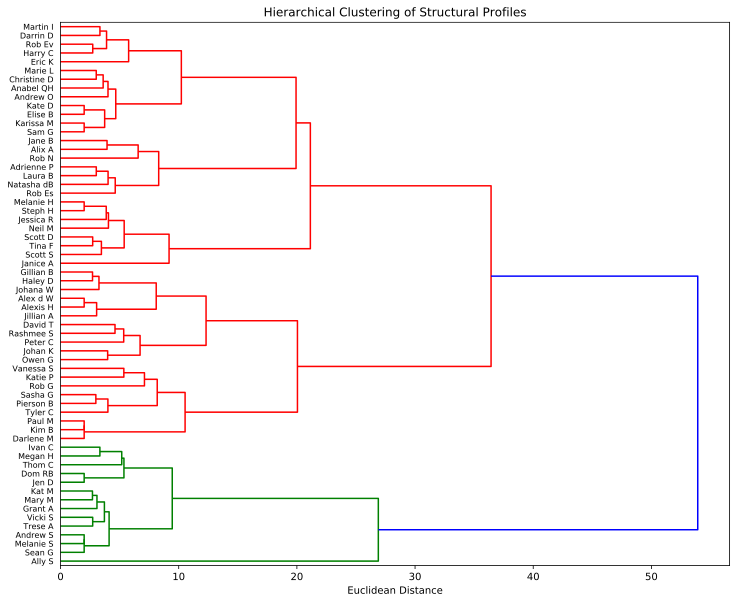

In [191]:
plt.figure(figsize=(12, 10))
plt.title('Hierarchical Clustering of Structural Profiles')
plt.xlabel('Euclidean Distance')

d = hierarchy.dendrogram(
    Z,
    distance_sort=True,
    leaf_rotation=0,  # rotates the x axis labels
    leaf_font_size=8,  # font size for the x axis labels
    orientation='right', 
    labels = [n for n in ego.nodes()])
plt.show()

Let's break down this plot. The first thing you need to know is that dendrograms are often plotted vertically, with the data points at the bottom. I have rotated the plot here so that it is displayed horizontally. I did this because it makes it possible to read the names of the nodes assigned to different clusters, which is very important for our analysis. Below, I refer vertical and horizontal lines on the graph. I mean for *this* specific dendrogram. If the graph is plotted vertically, vertical lines will become horizontal and horizontal lines will become vertical, but the process of interpreting the graph remains the same. 

First, look on the far left, next to the node names but inside the graph and to the right of 0. These lines that connect to individual data points are called 'leaves.' As you follow the leaves along the x-axis, they quickly reach the first of multiple vertical lines. Those vertical lines connect the leaves for individual data points into the first, and lowest level cluster. The branches are called 'clades.' If you are reading left to right, the clades represent smaller clusters being merged into larger clusters. If you read right to left, it's the opposite: larger clusters being subdivided into smaller ones. 

Each short vertical line along the x-axis represents a high-level of clustering. In other words, as you move along the x-axis, smaller clusters of similar nodes are merged into larger clusters of less similar nodes; because they are less similar, they are more distant in Euclidean space. When you get to the very end of the x-axis, all nodes in the network are part of the same (very inclusive!) cluster. 

The x-axis shows Euclidean distance. In other words, the degree of difference between the branches. The longer the line is along that axis, the greater the difference between the data points in the cluster. So if you cut the tree at max distance = 30, the nodes within a cluster will be substantially more diverse than if we cut it at 10. **Connecting back to the network concept of equivalence**, cutting the tree closer to the left of the tree, where Euclidean distances are short, is closer to the idea of structural equivalence. The further to the right the cut, where distance scores are higher, the more we relax our standards for equivalence. 

In short, cluster assignments towards the left of the graph will be more numerous and more exclusive. They will consist of a small number of nodes that have a high degree of similarity. As you move further towards the left the clusters become larger, more inclusive, and the nodes are less similar *but still similar*, to a point. The trick is that you, as the analyst, has to make a decision about where to cut this tree and assign cluster membership. For example, if you cut the three at maximum distance = 30 (on the x-axis), then there would be three clusters, or "blocks." If you cut it at 23, there would be 4 clusters / blocks. If you cut it at 12, there would be 7 clusters / blocks, and so on. 

There are some automated methods for making this decision, but honestly they are not particularly good and, wherever possible, you should probably make an informed decision about where to cut the tree using your substantive knowledge of the case as an analyst. 

Before getting into actually cutting the tree and analyzing blocks, let's consider one more concept related to hierarchical clustering: the Cophenet correlation coefficient. The Cophenet correlation coefficient is a measure of how well a dendrogram preserves the distances between the original data points. It does so by correlating the actual pairwise distances in the data to those implied by the hierarchical cluster analysis. Scores closer to 1 are better. 

In [192]:
c, coph_dists = hierarchy.cophenet(Z, pdist(distances))
c

0.7681362704508349

Now let's cut the tree. Based on some examination of the dendrogram (and again, knowing the people in this network), I will cut the tree at 10. We can do this function `fcluster()`.

In [193]:
max_d = 10
clusters = hierarchy.fcluster(Z, max_d, criterion='distance')

Now that we have each node assigned to a cluster, we can put this information into a `dictionary` format and use it to construct a network of equivalent blocks. We will use the `induced_graph()` function from earlier in this module to construct this aggregated network. 

In [194]:
nodes = [n for n in ego.nodes()]
blocks = dict(zip(nodes,clusters))
# blocks # uncomment if you want to see the dict with block membership

In [195]:
blocks

{'Ally S': 2,
 'Megan H': 1,
 'Ivan C': 1,
 'Alix A': 8,
 'Thom C': 1,
 'Rob N': 8,
 'Laura B': 8,
 'Owen G': 5,
 'Rashmee S': 5,
 'Rob G': 4,
 'Katie P': 4,
 'Vanessa S': 4,
 'Peter C': 5,
 'Pierson B': 4,
 'Sasha G': 4,
 'Tyler C': 4,
 'Jillian A': 6,
 'David T': 5,
 'Adrienne P': 8,
 'Rob Es': 8,
 'Steph H': 7,
 'Scott S': 7,
 'Jen D': 1,
 'Dom RB': 1,
 'Trese A': 1,
 'Grant A': 1,
 'Mary M': 1,
 'Kat M': 1,
 'Melanie S': 1,
 'Andrew S': 1,
 'Vicki S': 1,
 'Sean G': 1,
 'Jane B': 8,
 'Eric K': 10,
 'Janice A': 7,
 'Jessica R': 7,
 'Andrew O': 9,
 'Haley D': 6,
 'Kim B': 3,
 'Paul M': 3,
 'Darlene M': 3,
 'Neil M': 7,
 'Tina F': 7,
 'Scott D': 7,
 'Melanie H': 7,
 'Natasha dB': 8,
 'Alexis H': 6,
 'Alex d W': 6,
 'Johana W': 6,
 'Christine D': 9,
 'Marie L': 9,
 'Darrin D': 10,
 'Harry C': 10,
 'Gillian B': 6,
 'Anabel QH': 9,
 'Johan K': 5,
 'Rob Ev': 10,
 'Martin I': 10,
 'Elise B': 9,
 'Kate D': 9,
 'Sam G': 9,
 'Karissa M': 9}

In [196]:
bmod = community.induced_graph(blocks, ego)

Finally, let's visualize the the aggregated network of equivalent blocks. We will set the width of the edges to be a function of the number of ties between nodes from one block to another. 

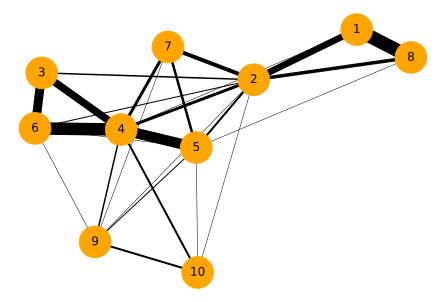

In [197]:
weights = [bmod[u][v]['weight'] / 2 for u,v in bmod.edges()]
pos = nx.spring_layout(bmod, seed = 13)
nx.draw(bmod, pos = pos, width=weights, node_size = 1000, with_labels = True, node_color = 'orange')

To help interpret this graph, we can print the names of nodes that belong to a block we want to understand. Let's write a quick function to do that. 

In [198]:
def interpret_block(block_to_interpret, block):
    print('-----------------\nNODES IN BLOCK {}:\n-----------------'.format(block_to_interpret))
    for k,v in block.items():
        if v == block_to_interpret:
            print(k)

We can either look at the names for one individual block:

In [199]:
interpret_block(4, blocks)

-----------------
NODES IN BLOCK 4:
-----------------
Rob G
Katie P
Vanessa S
Pierson B
Sasha G
Tyler C


Or we can print the names for nodes in each block. 

In [200]:
for i in range(1,len(bmod)+1):
    interpret_block(i, blocks)

-----------------
NODES IN BLOCK 1:
-----------------
Megan H
Ivan C
Thom C
Jen D
Dom RB
Trese A
Grant A
Mary M
Kat M
Melanie S
Andrew S
Vicki S
Sean G
-----------------
NODES IN BLOCK 2:
-----------------
Ally S
-----------------
NODES IN BLOCK 3:
-----------------
Kim B
Paul M
Darlene M
-----------------
NODES IN BLOCK 4:
-----------------
Rob G
Katie P
Vanessa S
Pierson B
Sasha G
Tyler C
-----------------
NODES IN BLOCK 5:
-----------------
Owen G
Rashmee S
Peter C
David T
Johan K
-----------------
NODES IN BLOCK 6:
-----------------
Jillian A
Haley D
Alexis H
Alex d W
Johana W
Gillian B
-----------------
NODES IN BLOCK 7:
-----------------
Steph H
Scott S
Janice A
Jessica R
Neil M
Tina F
Scott D
Melanie H
-----------------
NODES IN BLOCK 8:
-----------------
Alix A
Rob N
Laura B
Adrienne P
Rob Es
Jane B
Natasha dB
-----------------
NODES IN BLOCK 9:
-----------------
Andrew O
Christine D
Marie L
Anabel QH
Elise B
Kate D
Sam G
Karissa M
-----------------
NODES IN BLOCK 10:
---------

The final step in this process is an interpretive one. With results like these, the analyst typically inspects each block and the relationships between the blocks and draws some sort of conclusions about the structure of the positions in the network. Some approaches, for example based on role theory, would use block memberships and the relationships between blocks to infer role relationships, but this is not the only possible interpretation. 

In this case, for my network, the blocks identified make a great deal of sense. My Partner Ally S is structurally very different than anyone else in the network, and is therefore assigned to her own block. The other blocks consist of people who are relationally very similar. In fact, it even differentiated between faculty, staff, undergrad, and grad students in my personal network at the University of Waterloo, which is rather remarkable given that the algorithms know nothing about these specific roles. 

### <font color="green">YOUR TURN! (Question 8)</font> <a id='yt8'></a>

Question is Worth: <font color="green">1 point</font>

In the cell below, reproduce this equivalence / block model analysis for your own ego network. Be sure to follow all the steps, including making a decision about where to cut the dendrogram and visualization of the connections across blocks. 

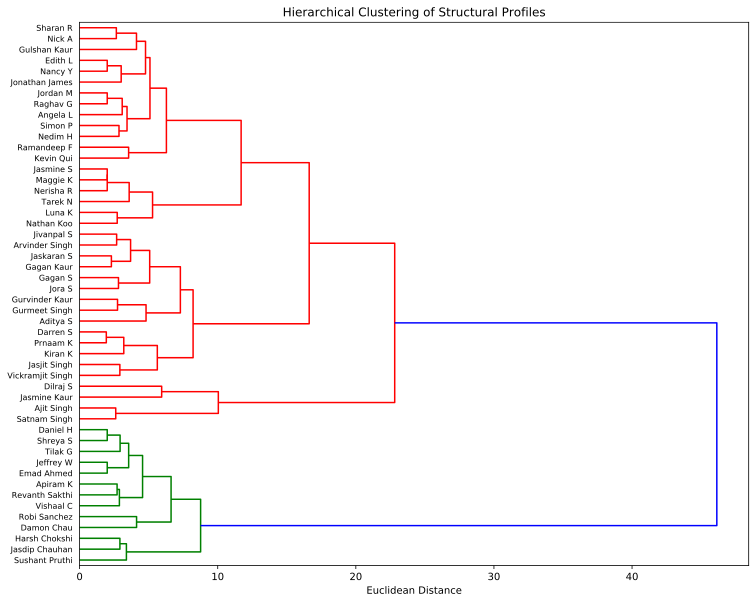

-----------------
NODES IN BLOCK 1:
-----------------
Jasdip Chauhan
Sushant Pruthi
Harsh Chokshi
-----------------
NODES IN BLOCK 2:
-----------------
Damon Chau
Robi Sanchez
-----------------
NODES IN BLOCK 3:
-----------------
Emad Ahmed
Tilak G
Shreya S
Revanth Sakthi
Daniel H
Jeffrey W
Vishaal C
Apiram K
-----------------
NODES IN BLOCK 4:
-----------------
Satnam Singh
Ajit Singh
-----------------
NODES IN BLOCK 5:
-----------------
Jasmine Kaur
-----------------
NODES IN BLOCK 6:
-----------------
Dilraj S
-----------------
NODES IN BLOCK 7:
-----------------
Vickramjit Singh
Jasjit Singh
-----------------
NODES IN BLOCK 8:
-----------------
Kiran K
Prnaam K
Darren S
-----------------
NODES IN BLOCK 9:
-----------------
Gurmeet Singh
Gurvinder Kaur
Aditya S
-----------------
NODES IN BLOCK 10:
-----------------
Jora S
Gagan S
-----------------
NODES IN BLOCK 11:
-----------------
Gagan Kaur
Arvinder Singh
Jivanpal S
Jaskaran S
-----------------
NODES IN BLOCK 12:
---------------

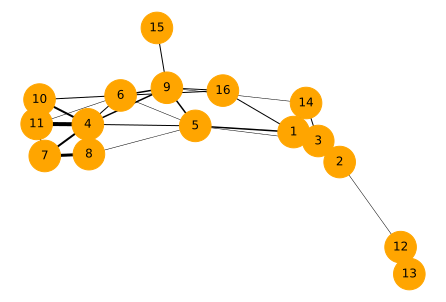

In [201]:
# Your Answer Here
ego_am_stu = nx.adjacency_matrix(ego_stu)
distances_stu = euclidean_distances(ego_am_stu)
Z_stu = hierarchy.linkage(distances_stu, 'ward') 

plt.figure(figsize=(12, 10))
plt.title('Hierarchical Clustering of Structural Profiles')
plt.xlabel('Euclidean Distance')

d = hierarchy.dendrogram(
    Z_stu,
    distance_sort=True,
    leaf_rotation=0,  # rotates the x axis labels
    leaf_font_size=8,  # font size for the x axis labels
    orientation='right', 
    labels = [n for n in ego_stu.nodes()])
plt.show()

c, coph_dists = hierarchy.cophenet(Z_stu, pdist(distances_stu))
max_d_stu = 5
clusters_stu = hierarchy.fcluster(Z_stu, max_d_stu, criterion='distance')

nodes_stu = [n for n in ego_stu.nodes()]
blocks_stu = dict(zip(nodes_stu,clusters_stu))
bmod_stu = community.induced_graph(blocks_stu, ego_stu)

weights = [bmod_stu[u][v]['weight'] / 2 for u,v in bmod_stu.edges()]
pos = nx.spring_layout(bmod_stu, seed = 13)
nx.draw(bmod_stu, pos = pos, width=weights, node_size = 1000, with_labels = True, node_color = 'orange')

for i in range(1,len(bmod_stu)+1):
    interpret_block(i, blocks_stu)


### <font color="green">YOUR TURN! (Question 9)</font> <a id='yt9'></a>

Question is Worth: <font color="green">1 point</font>
    
In the cell below, interpret the results of the equivalence / block model analysis of your ego network. Feel free to use my interpretation of my network as a template. 

Within the dendrogram, the decision to split the blocks at a distance of 5 was to maintain a strict standard and incorporate a larger amount of blocks within the analysis since they begin to cluster at a larger level from that point which would lead to less interesting results. 

The blocks consist of people who are relatively similar in their structure and their role within the network. Interestingly, enough Dilraj is structurally different from everyone else given that he is central to many of my friends that are outside the program. Jasmine is very central to many groups within the network so a dedicated block for her makes a lot of sense. A lot of my program friends are grouped into one block with the differentiator most likely being their connection with Jasmine. For the most part, a lot of people are differentiated by their relation, age (Kevin & Ramandeep are older students I stay in contact with), school (high school friends are grouped into a block and same with program, same year friends and same club). Another interesting observation is the fact that my grandmother is in block 16 along with a diverse group (including my mentee Nick, former manager in JJ, and workmates in Nancy and Edith). Their structure and role seems to imply that they're close but far in their positioning within the network as close to a specifc set of individuals but far from the network in general. 

Within the agggregated visualization among the network blocks, the visualization reflects much of the knowledge known beforehand with a lot of similar relational blocks holding stronger ties among other blocks. For example, a lot of my BC friend groups (block 8 and 7) are heavily tied to block 4 & 11 which are many of mutual Toronto friends. 

# Combining Cluster Analysis and Centrality Analysis <a id='combo'></a>

We are going to wrap up this Module by briefly considering two simple ways of combining an centrality analysis with a cluster analysis. For clusters, we can use the results of a cohesive subgroup analysis or a positional analysis / block model. In fact, we could even use some attribute that is external to the network itself, such as organizational affiliations. 

The first option is to simply examine the distribution of centrality scores across mutually-exclusive communities identified by approaches like Louvain, or blocks. The second will be the use of a special class of centrality measures designed for *groups* of nodes rather than individual nodes. 

## Distributions of Centrality Scores Across Groups <a id='cdist'></a>

Earlier in the Module, we applied the Louvain community detection algorithm to my personal network and stored the results of the analysis in a `dictionary` called 'part' (short for partitions). To simplify subgroup comparisons, we will add this community membership data to our centralities `dataframe`. We will use the term "Modularity Class" instead of community because it is more precise. We will also add the block memberships to the `dataframe`.

In [202]:
centralities['Modularity Class'] = part.values()
centralities['Block'] = blocks.values()
centralities.sample(10)

,Degree,Eigenvector,Betweenness,Node ID,Current Flow Betweenness,Constraint,embeddedness,Modularity Class,Block
37,0.114754,0.074713,0.002129,Haley D,0.031081,0.282547,5,2,6
31,0.213115,0.181203,0.000146,Sean G,0.029273,0.234345,12,1,1
36,0.032787,0.029933,0.000000,Andrew O,0.010444,0.569877,1,0,9
53,0.098361,0.050848,0.000000,Gillian B,0.019216,0.318389,5,2,6
52,0.081967,0.016871,0.013236,Harry C,0.066059,0.428323,3,3,10
5,0.213115,0.148562,0.003722,Rob N,0.052297,0.196512,8,1,8
20,0.131148,0.056803,0.000328,Steph H,0.033846,0.347856,5,0,7
28,0.213115,0.181203,0.000146,Melanie S,0.029273,0.234345,12,1,1
58,0.032787,0.000359,0.000000,Elise B,0.010929,0.922500,1,3,9
0,0.737705,0.378778,0.555516,Ally S,0.523748,0.075842,12,0,2


We can now easily compare the distribution of centrality scores across communities / modularity classes. For example, let's compare the distribution of current flow betweenness, constraint, and eigenvector centrality across modularity classes. We will use the `stripplot` function in `Seaborn` to make these comparisons because it nicely jitters the individual points, showing clustering of nodes with similiar centralities. 

### Across Modularity Class

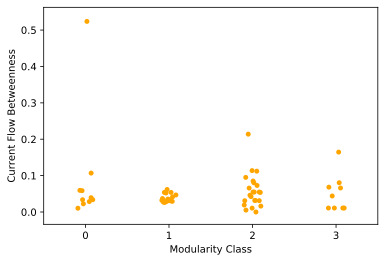

In [203]:
sns.stripplot(centralities["Modularity Class"], centralities["Current Flow Betweenness"], color = 'orange')

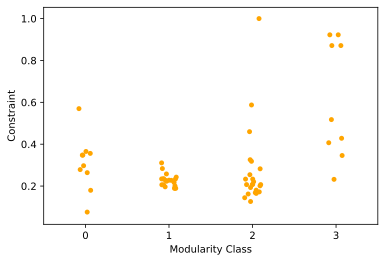

In [204]:
sns.stripplot(centralities["Modularity Class"], centralities["Constraint"], color = 'orange')

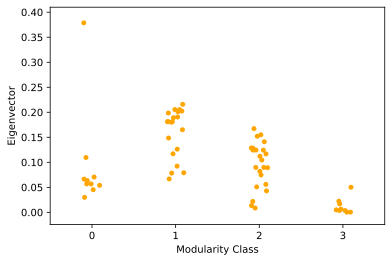

In [205]:
sns.stripplot(centralities["Modularity Class"], centralities["Eigenvector"], color = 'orange')

### Across Equivalent Blocks

Let's consider another application, this time using the blocks from our analysis of equivalence and structural positions. 

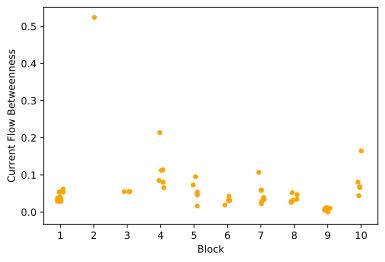

In [206]:
sns.stripplot(centralities["Block"], centralities["Current Flow Betweenness"], color = 'orange')

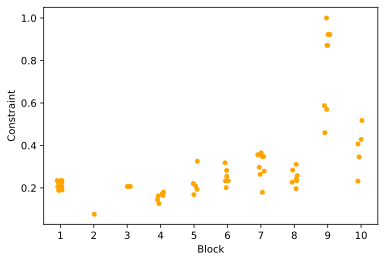

In [207]:
sns.stripplot(centralities["Block"], centralities["Constraint"], color = 'orange')

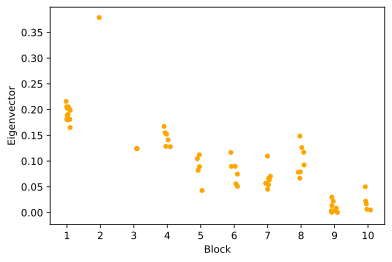

In [208]:
sns.stripplot(centralities["Block"], centralities["Eigenvector"], color = 'orange')

### Across $k$-Components / Embeddedness

Finally, let's compare across the deepest $k$-component a node is embedded in. When you interpret these graphs, test your understanding of the key concepts (e.g. constraint and embeddedness) by trying to explain the relationships you see in the graphs. 

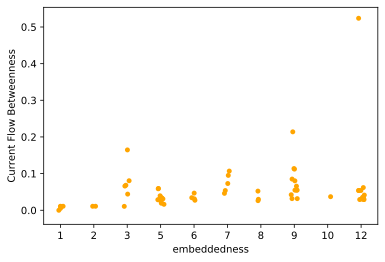

In [209]:
sns.stripplot(centralities["embeddedness"], centralities["Current Flow Betweenness"], color = 'orange')

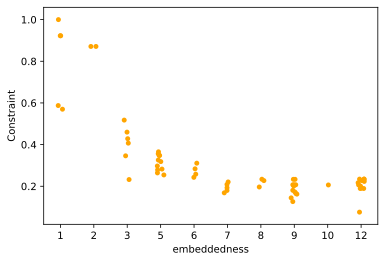

In [210]:
sns.stripplot(centralities["embeddedness"], centralities["Constraint"], color = 'orange')

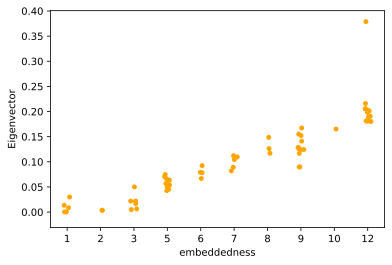

In [211]:
sns.stripplot(centralities["embeddedness"], centralities["Eigenvector"], color = 'orange')

## Group Centrality <a id='gc'></a>

Centrality measures have been developed with individual-level nodes in mind. Determining a group-level centrality score from an network where the nodes are individuals is a bit more complex than you might first expect. If you wanted to know how central the people from one organization are relative to another, or from city to another, or in one modularity class to another, you should use a centrality measure *designed* for groups of nodes in an individual-level network. These group centrality scores are still derived from individual-level scores, but they are more sophisticated than simple summing or averaging, which can produce misleading results when comparing groups. 

Here we will use two group centrality measures developed by Martin Everett and Steve Borgatti, two very influential network scientists and mathematical sociologists. The first is group degree centrality, the second is group betweenness centrality. 

The implementation of these methods in `networkx` requires passing a list of nodes that are part of some group, which could be exogenous to the network (e.g. the organization you work for) or endogenous to the network (e.g. the modularity class you are part of). To get that list, we will pull data from the Modularity Class column of our `centralities` `dataframe` and construct a list of lists. We can then apply the analysis to each community by iterating over the outer list. 

In [212]:
nodes_in_communities = centralities.groupby(['Modularity Class'])['Node ID'].apply(','.join).reset_index()

mcs = []
for index, row in nodes_in_communities.iterrows():
    mc = row['Node ID'].split(',')
    mcs.append(mc)
mcs

[['Ally S',
  'Steph H',
  'Scott S',
  'Janice A',
  'Jessica R',
  'Andrew O',
  'Neil M',
  'Tina F',
  'Scott D',
  'Melanie H'],
 ['Megan H',
  'Ivan C',
  'Alix A',
  'Thom C',
  'Rob N',
  'Laura B',
  'Adrienne P',
  'Rob Es',
  'Jen D',
  'Dom RB',
  'Trese A',
  'Grant A',
  'Mary M',
  'Kat M',
  'Melanie S',
  'Andrew S',
  'Vicki S',
  'Sean G',
  'Jane B',
  'Natasha dB'],
 ['Owen G',
  'Rashmee S',
  'Rob G',
  'Katie P',
  'Vanessa S',
  'Peter C',
  'Pierson B',
  'Sasha G',
  'Tyler C',
  'Jillian A',
  'David T',
  'Haley D',
  'Kim B',
  'Paul M',
  'Darlene M',
  'Alexis H',
  'Alex d W',
  'Johana W',
  'Christine D',
  'Marie L',
  'Gillian B',
  'Anabel QH',
  'Johan K'],
 ['Eric K',
  'Darrin D',
  'Harry C',
  'Rob Ev',
  'Martin I',
  'Elise B',
  'Kate D',
  'Sam G',
  'Karissa M']]

In [213]:
for mc in mcs:
    print('The group betweenness centrality score for Modularity Class {} is: {}.'.format(mcs.index(mc), np.round(nx.group_betweenness_centrality(ego, mc), 3)))

The group betweenness centrality score for Modularity Class 0 is: 0.504.
The group betweenness centrality score for Modularity Class 1 is: 0.0.
The group betweenness centrality score for Modularity Class 2 is: 0.079.
The group betweenness centrality score for Modularity Class 3 is: 0.0.


Now that you have seen how it works, let's compute the scores for both group centrality measures, put them in a dataframe, and then visualize them in a simple scatterplot. 

In [214]:
group_bc = [nx.group_betweenness_centrality(ego, mc) for mc in mcs]
group_dc = [nx.group_degree_centrality(ego, mc) for mc in mcs]

In [215]:
centralities_group = pd.DataFrame([group_bc, group_dc]).T
centralities_group['Modularity Class'] = centralities_group.index
centralities_group.columns = ['Group Betweenness', 'Group Degree', 'Modularity Class']
centralities_group

,Group Betweenness,Group Degree,Modularity Class
0,0.503514,0.692308,0
1,0.000000,0.071429,1
2,0.079141,0.256410,2
3,0.000104,0.075472,3


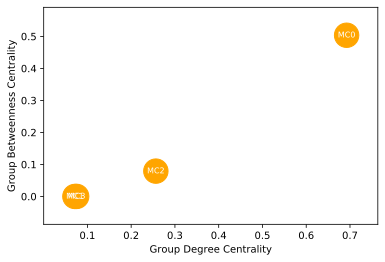

In [216]:
plt.scatter(centralities_group['Group Degree'], centralities_group['Group Betweenness'], s = 600, c = 'orange')
plt.xlabel('Group Degree Centrality', fontsize = 10)
plt.ylabel('Group Betweenness Centrality', fontsize = 10)

for i, names in enumerate(centralities_group['Modularity Class']):
    x = centralities_group['Group Degree'][i]
    y = centralities_group['Group Betweenness'][i]
    plt.text(x,y, 'MC{}'.format(names), fontsize=8, ha='center', va='center', color='white')

Our analysis clearly shows that Modularity Class 0 has the highest group degree centrality *and* the highest group betweenness centrality, even though the distribution of the individual scores across communities does not differ radically (we know this from the previous plots comparing the distribution of scores across modularity classes). We can easily query the dataframe to see what nodes are part of that modularity class. 

In [217]:
centralities[centralities['Modularity Class'] == 0]

,Degree,Eigenvector,Betweenness,Node ID,Current Flow Betweenness,Constraint,embeddedness,Modularity Class,Block
0,0.737705,0.378778,0.555516,Ally S,0.523748,0.075842,12,0,2
20,0.131148,0.056803,0.000328,Steph H,0.033846,0.347856,5,0,7
21,0.081967,0.045218,0.000000,Scott S,0.022500,0.365407,5,0,7
34,0.245902,0.109616,0.018117,Janice A,0.106952,0.179864,7,0,7
35,0.163934,0.070483,0.006051,Jessica R,0.059508,0.264091,5,0,7
36,0.032787,0.029933,0.000000,Andrew O,0.010444,0.569877,1,0,9
41,0.147541,0.066384,0.004935,Neil M,0.058673,0.278736,5,0,7
42,0.131148,0.063540,0.001624,Tina F,0.039463,0.297299,5,0,7
43,0.114754,0.053954,0.000000,Scott D,0.028680,0.356169,5,0,7
44,0.131148,0.056803,0.000328,Melanie H,0.033846,0.347856,5,0,7


Once again, let's go through this process for blocks as well. 

In [218]:
nodes_in_blocks = centralities.groupby(['Block'])['Node ID'].apply(','.join).reset_index()

blo = []
for index, row in nodes_in_blocks.iterrows():
    b = row['Node ID'].split(',')
    blo.append(b)
blo

[['Megan H',
  'Ivan C',
  'Thom C',
  'Jen D',
  'Dom RB',
  'Trese A',
  'Grant A',
  'Mary M',
  'Kat M',
  'Melanie S',
  'Andrew S',
  'Vicki S',
  'Sean G'],
 ['Ally S'],
 ['Kim B', 'Paul M', 'Darlene M'],
 ['Rob G', 'Katie P', 'Vanessa S', 'Pierson B', 'Sasha G', 'Tyler C'],
 ['Owen G', 'Rashmee S', 'Peter C', 'David T', 'Johan K'],
 ['Jillian A', 'Haley D', 'Alexis H', 'Alex d W', 'Johana W', 'Gillian B'],
 ['Steph H',
  'Scott S',
  'Janice A',
  'Jessica R',
  'Neil M',
  'Tina F',
  'Scott D',
  'Melanie H'],
 ['Alix A',
  'Rob N',
  'Laura B',
  'Adrienne P',
  'Rob Es',
  'Jane B',
  'Natasha dB'],
 ['Andrew O',
  'Christine D',
  'Marie L',
  'Anabel QH',
  'Elise B',
  'Kate D',
  'Sam G',
  'Karissa M'],
 ['Eric K', 'Darrin D', 'Harry C', 'Rob Ev', 'Martin I']]

In [219]:
group_bc_blo = [nx.group_betweenness_centrality(ego, b) for b in blo]
group_dc_blo = [nx.group_degree_centrality(ego, b) for b in blo]

In [220]:
centralities_group_blo = pd.DataFrame([group_bc_blo, group_dc_blo]).T
centralities_group_blo['Modularity Class'] = centralities_group_blo.index +1 # add one because index starts at 0
centralities_group_blo.columns = ['Group Betweenness', 'Group Degree', 'Block']
centralities_group_blo

,Group Betweenness,Group Degree,Block
0,0.004948,0.183673,1
1,0.555516,0.737705,2
2,0.031092,0.203390,3
3,0.268212,0.446429,4
4,0.047401,0.228070,5
5,0.004311,0.214286,6
6,0.002428,0.185185,7
7,0.000898,0.218182,8
8,0.000000,0.166667,9
9,0.135428,0.140351,10


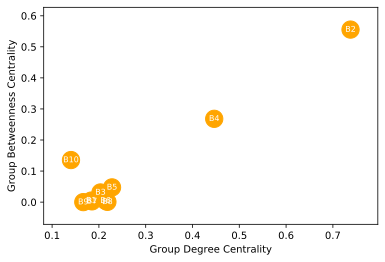

In [221]:
plt.scatter(centralities_group_blo['Group Degree'], centralities_group_blo['Group Betweenness'], s = 300, c = 'orange')
plt.xlabel('Group Degree Centrality', fontsize = 10)
plt.ylabel('Group Betweenness Centrality', fontsize = 10)

for i, names in enumerate(centralities_group_blo['Block']):
    x = centralities_group_blo['Group Degree'][i]
    y = centralities_group_blo['Group Betweenness'][i]
    plt.text(x,y, 'B{}'.format(names), fontsize=8, ha='center', va='center', color='white')

Based on this analysis, blocks 1, 3, and 9 are the most central. 

In [ ]:
who = [2, 4, 10]
for w in who:
    print(interpret_block(w))

### <font color="green">YOUR TURN! (Question 10)</font> <a id='yt9'></a>

Question is Worth: <font color="green">1 point</font>

In the previous cells related to group centrality analysis, we copy and pasted a fair amount of code to do our analysis. In the cell below, write a custom function that will visualize the distribution of a centrality score across categories of a group of nodes (modularity classes, k-components / embeddedness, or blocks). Finally, run your function on your own ego network to ensure it works as expected. 

In [224]:
# Your Answer Here
def visualize_centralities (graph, centralities, category):
    node_in_category = centralities.groupby([category])['Node ID'].apply(','.join).reset_index()
    group = []
    for index, row in node_in_category.iterrows():
        b = row['Node ID'].split(',')
        group.append(b)
        group
        
    group_bc_category = [nx.group_betweenness_centrality(graph, mc) for mc in mcs]
    group_dc_category = [nx.group_degree_centrality(grraph, mc) for mc in mcs]
        
    centralities_group = pd.DataFrame([group_bc_category, group_dc_category]).T
    if category == 'Block':
        centralities_group[category] = centralities_group.index+1
    else:
        centralities_group.columns = ['Group Betweenness', 'Group Degree', 'Modularity Class']
    
    centralities_group

    plt.scatter(centralities_group['Group Degree'], centralities_group['Group Betweenness'], s = 600, c = 'orange')
    plt.xlabel('Group Degree Centrality', fontsize = 10)
    plt.ylabel('Group Betweenness Centrality', fontsize = 10)

    for i, names in enumerate(centralities_group['Modularity Class']):
        x = centralities_group['Group Degree'][i]
        y = centralities_group['Group Betweenness'][i]
        plt.text(x,y, 'MC{}'.format(names), fontsize=8, ha='center', va='center', color='white')
    
    return centralities_group

visualize_centralities(ego_stu, centralities_stu,'Modularity Class' )
# visualize_centralities(ego_stu, centralities_stu, 'embeddedness')
# visualize_centralities(ego_stu, centralities_stu, 'Block')



KeyError: 'Modularity Class'

<hr>

# <font color="green">Do You See Something That Could be Better?</font>

I am committed to collecting student feedback to continuously improve this course for future students. I would like to invite you to help me make those improvements. 

As you worked on this module, did you notice anything that could be improved? For example, did you find a typo in the module notebook **or in the assigned reading**? Did you find the explanation of a particular concept or block of code confusing? Is there something that just isn’t clicking for you? 

If you have any feedback for the content in this module, please enter it into the text block below. I will review feedback each week and make a list of things that should be changed before the next offering. 

Please know that *nothing you say here, however critical, will impact how I evaluate your work in this course*. There is no risk that I will assign a lower grade to you if you provide critical feedback. In fact, if the feedback you provide is thoughtful and constructive, I will assign up to 3% bonus marks on your final course grade. 

Thanks for your help improving the course! 

# Your Feedback Here :-) 

<hr>

# REFERENCES <a id='refs'></a>

* Borgatti, Steve Martin Everett, and Jeff Johnson. 2016. *Analyzing Social Networks*. Sage. 
* Borgatti, Stephen. 2005. "Centrality and network flow." *Social Networks*. 27(1): 55-71.
* Brandes, Ulrik, and Daniel Fleischer. 2005. "Centrality measures based on current flow." *Annual symposium on theoretical aspects of computer science.* Springer, Berlin, Heidelberg. 
* Burt, Ron. 2004. "Structural Holes and Good Ideas." *American Journal of Sociology*. 110(2):349-399. 
* Burt, Ron. 2005. *Brokerage and Closure: An Introduction to Social Capital.* Oxford University Press.
* Centola, Damon. 2018. *How Behavior Spreads: The Science of Complex Contagions*. Princeton University Press. 
* Everett, Martin and Steve Borgatti. 1999. "The Centrality of Groups and Classes." *Journal of Mathematical Sociology.* 23(3): 181-201.
* Jackson, Matthew O. 2019. *The Human Network*. Pantheon Books.
* Kadushin, Charles. 2012. *Understanding Social Networks*. Oxford University Press.
* Palla, Gergely, Imre Derényi, Illés Farkas & Tamás Vicsek. 2005. "Uncovering the overlapping community structure of complex networks in nature and society." *Nature*. 435(7043):814-818.
* Scott, John. 2013. *Social Network Analysis*. Sage.
* Simmel, Georg. 1922 [1955]. *Conflict and the Web of Group Affiliations*. Translated and edited by Kurt Wolff, Glencoe, IL: Free Press.